In [1]:
from AngioMorphPCA.io import mkdir

import os
from datetime import datetime

# 定义存储文件夹的路径
aligned_backup_path = "./aligned_bkup/"

def get_latest_backup_folder(base_path):
    # 获取路径下所有文件夹的列表
    backup_folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    # 按文件夹名称排序（假设文件夹名称格式为yymmddhhmmss）
    backup_folders.sort(reverse=True)

    # 获取最新的文件夹
    latest_backup_folder = backup_folders[0] if backup_folders else None

    # 返回最新文件夹的路径
    if latest_backup_folder:
        return os.path.join(base_path, latest_backup_folder)
    else:
        return None

# 循环直到用户输入 'y' 或 'n'
while True:
    use_existing_aligned = input("是否使用现有的对齐文件夹？(y/n): ").lower()
    if use_existing_aligned in ['y', 'n']:
        break
    else:
        print("无效输入，请输入 'y' 或 'n'.")

if use_existing_aligned == 'y':
    latest_folder_path = get_latest_backup_folder(aligned_backup_path)
    if latest_folder_path:
        print(f"使用最新的既存文件。路径: {latest_folder_path}")
    else:
        print("未找到任何文件夹")
else:
    # 获取当前时间
    now = datetime.now()
    
    # 格式化时间为 yymmddhhmmss
    formatted_time = now.strftime("%y%m%d%H%M%S")
    
    # 创建新的文件夹
    new_folder_path = os.path.join(aligned_backup_path, formatted_time)
    os.makedirs(new_folder_path)
    print(f"已创建新文件夹: {new_folder_path}")


已创建新文件夹: ./aligned_bkup/241007101348


In [5]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from scipy.stats import linregress
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.signal import find_peaks
from matplotlib import cm
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from AngioMorphPCA.make_figures import set_x_ticks_normalized
import fdasrsf as fs
from sklearn.svm import SVC
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from skimage import measure
import vtk
import pandas as pd

sns.set_theme(style="white", color_codes=True)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


print (glob.glob("../geom_aligned_curves/*.npy"))
# curve_bs = np.array(curve_bs)
curve_bs = np.load("../geom_aligned_curves/geomstats_aligned_to_first.npy")
curve_cs = np.load("../geom_aligned_curves/geomstats_aligned_to_frechet.npy")
unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves/total_files.npy")[:curve_bs.shape[0]]

print ("curve_bs:", curve_bs.shape)
print (curve_cs.shape)
print (unaligned_curvatures.shape)
print (files.shape)

brava_num = len(curve_bs)
print (brava_num)
# k_sampling_points = 120

# curves_r3 = DiscreteCurvesStartingAtOrigin(
#     ambient_dim=3, k_sampling_points=k_sampling_points, equip=False
# )

# curves_r3.equip_with_metric(SRVMetric)

# mean = FrechetMean(curves_r3)
# mean.fit(curve_cs)

# mean_estimate = mean.estimate_
# tangent_base = mean.estimate_

# curvatures = []
# torsions = []

# for i in range(len(curve_cs)):
#     c,t = compute_curvature_and_torsion(curve_cs[i]*100)
#     fft_c = remove_high_freq_components(c,0.06)
#     fft_t = remove_high_freq_components(t,0.06)
#     curvatures.append(fft_c)
#     torsions.append(fft_t)
# curvatures = np.array(curvatures)
# torsions = np.array(torsions)


# g_dist_to_frechet = []
# for i in range(len(curve_cs)):
#     g_dist_to_frechet.append(curves_r3.metric.dist(mean_estimate, curve_cs[i]))
# g_dist_to_frechet = np.array(g_dist_to_frechet)

# # 获取按距离从小到大排序的索引
# sorted_indices = np.argsort(g_dist_to_frechet)

# # 根据这些索引重新排列距离数组
# g_dist_to_frechet = g_dist_to_frechet[sorted_indices]

# # 对曲率进行相应的从大到小排序
# curvatures = curvatures[sorted_indices]
# torsions = torsions[sorted_indices]
# files = files[sorted_indices]
# curve_cs = curve_cs[sorted_indices]
# curve_bs = curve_bs[sorted_indices]

# g_dist_min = 100000
# g_dist_max = 0
# g_dist_min_index = (0,0)
# g_dist_max_index = (0,0)
# g_dist = []
# g_dist_mat = np.zeros((len(curve_bs),len(curve_bs)))
# for i in range(len(curve_bs)):
#     # geodesic_distance = curves_r3.metric.dist(mean_estimate, curve_bs[i])
#     for j in range(len(curve_bs)):
#         g_dist_mat[i,j] = curves_r3.metric.dist(curve_bs[i], curve_bs[j])
    
#     if i != j and g_dist_mat[i,j] < g_dist_min:
#         g_dist_min = g_dist_mat[i,j]
#         g_dist_min_index = (i,j)
#     elif i != j and g_dist_mat[i,j] > g_dist_max:
#         g_dist_max = g_dist_mat[i,j]
#         g_dist_max_index = (i,j)
#     g_dist.append(g_dist_mat[i,j])
# print (g_dist_min_index, g_dist_max_index)


# time = np.linspace(0, 1, len(curvatures[0]))  # 时间点
# f = curvatures.copy().T  # 数据
# # f = sample_c.T
# obj_curvature = fs.fdawarp(f,time)
# # 执行对齐
# obj_curvature.srsf_align(parallel=True, MaxItr=1500)

# f = torsions.copy().T  # 数据
# obj_torsion = fs.fdawarp(f,time)
# # 执行对齐
# obj_torsion.srsf_align(parallel=True, MaxItr=5000)

# c_peak_indices, _ = find_peaks(obj_curvature.fmean, height=0)
# t_peak_indices, _ = find_peaks(obj_torsion.fmean, height=0)
# c_peak_indices = c_peak_indices[:5]
# t_peak_indices = t_peak_indices[:5]
# print (c_peak_indices)

# c_peak_values = []
# t_peak_values = []
# c_peak_movement = []
# t_peak_movement = []
# for i in range(len(curvatures)):
#     c_peak_values.append(obj_curvature.fn[:,i][c_peak_indices]/obj_curvature.fmean[c_peak_indices])
#     t_peak_values.append(obj_torsion.fn[:,i][t_peak_indices]/obj_torsion.fmean[t_peak_indices])
#     c_peak_movement.append(obj_curvature.gam[:,i][c_peak_indices] - c_peak_indices/len(curvatures[0]))
#     t_peak_movement.append(obj_curvature.gam[:,i][t_peak_indices] - t_peak_indices/len(curvatures[0]))
    
# c_peak_values = np.array(c_peak_values)
# t_peak_values = np.array(t_peak_values)
# c_peak_movement = np.array(c_peak_movement)
# t_peak_movement = np.array(t_peak_movement)
# print (c_peak_values.shape)
# print (c_peak_movement.shape)

# c_peak_values_transposed = list(zip(*c_peak_values))
# t_peak_values_transposed = list(zip(*t_peak_values))

# kappa_moves = []
# tau_moves = []
# kappa_values = []
# tau_values = []
# for i in range(len(curvatures)):
#     kappa_moves.append(np.mean(c_peak_movement[i]))
#     tau_moves.append(np.mean(t_peak_movement[i]))
#     kappa_values.append(np.mean(c_peak_values[i]))
#     tau_values.append(np.mean(t_peak_values[i]))
# kappa_moves = np.array(kappa_moves)
# tau_moves = np.array(tau_moves)
# kappa_values = np.array(kappa_values)
# tau_values = np.array(tau_values)

['../geom_aligned_curves\\curvatures.npy', '../geom_aligned_curves\\geomstats_aligned_to_first.npy', '../geom_aligned_curves\\geomstats_aligned_to_first_with_a.npy', '../geom_aligned_curves\\geomstats_aligned_to_frechet.npy', '../geom_aligned_curves\\geomstats_aligned_to_frechet_with_a.npy', '../geom_aligned_curves\\total_files_with_a.npy']
curve_bs: (79, 119, 3)
(79, 119, 3)
(79, 120)
(79,)
79


In [4]:
np.save(new_folder_path + "/obj_curvature_fn.npy",obj_curvature.fn)
np.save(new_folder_path + "/obj_torsion_fn.npy",obj_torsion.fn)
np.save(new_folder_path + "/obj_curvature_gam.npy",obj_curvature.gam)
np.save(new_folder_path + "/obj_torsion_gam.npy",obj_torsion.gam)
np.save(new_folder_path + "/obj_curvature_mean.npy",obj_curvature.fmean)
np.save(new_folder_path + "/obj_torsion_mean.npy",obj_torsion.fmean)

print (obj_curvature.gam.shape)


(119, 79)


- The first curve is not aligned in `curve_bs`.
- `curve_bs` and `curve_cs` have the same parameterization.

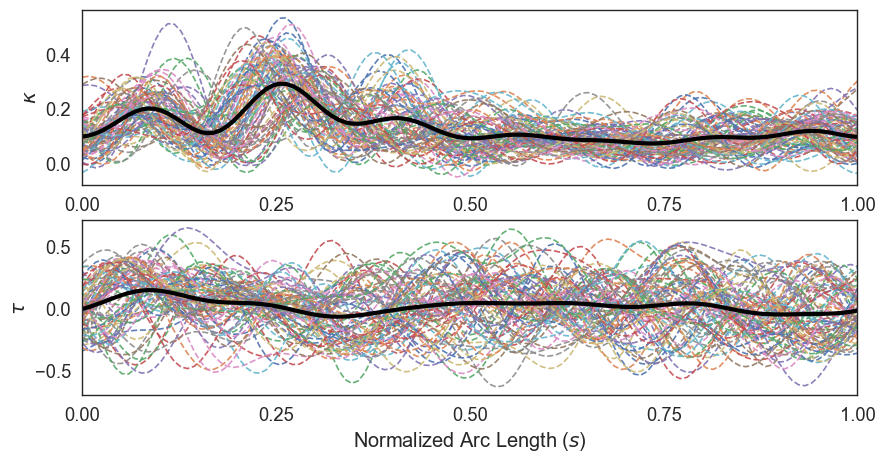

In [5]:
# 假设 curvatures 是已定义的，每个元素的长度为120
# siphon_ranges 为每个curvatures中siphon段的起始和结束索引列表



sns.set_context("paper", font_scale=1.5)
fig = plt.figure(figsize=(10, 5), dpi=100)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 2])

ax1 = fig.add_subplot(gs[0, 0])  # 第一行，第一列
ax2 = fig.add_subplot(gs[1, 0])  # 第二行，第一列
# ax3 = fig.add_subplot(gs[2, 0])  # 第三行，第一列 (用于绘制KDE)

# 绘制curvatures和torsions的线图
for i in range(len(curvatures)):
    sns.lineplot(x=np.arange(len(curvatures[i])), y=curvatures[i], ax=ax1, alpha=0.9, linestyle='--', linewidth=1.2)
    sns.lineplot(x=np.arange(len(torsions[i])), y=torsions[i], ax=ax2, alpha=0.9, linestyle='--', linewidth=1.2)

sns.lineplot(x=np.arange(len(np.mean(curvatures, axis=0))), y=np.mean(curvatures, axis=0), ax=ax1, color='black', linewidth=3)
sns.lineplot(x=np.arange(len(np.mean(torsions, axis=0))), y=np.mean(torsions, axis=0), ax=ax2, color='black', linewidth=3)


# # 绘制原始概率分布
# ax3.fill_between(range(120), siphon_probability, color="skyblue", alpha=0.4)

# # 绘制高斯拟合曲线
# ax3.plot(x_values, fitted_pdf, ':', linewidth=2, label='Gaussian Fit',color="dimgray")


def set_x_ticks_normalized(ax,x_array,num=5):
    ax.set_xlim(0, len(x_array) - 1)
    ax.set_xticks(np.linspace(0, len(x_array)-1, num=num))
    ax.set_xticklabels(['{:.2f}'.format(x) for x in np.linspace(0, 1, num=num)])
    ax.autoscale(enable=True, axis='x', tight=True)


set_x_ticks_normalized(ax1,curvatures[0])
set_x_ticks_normalized(ax2,torsions[0])
ax1.set_ylabel('$\kappa$')
ax2.set_ylabel('$\\tau$')
ax2.set_xlabel('Normalized Arc Length ($s$)')
plt.show()



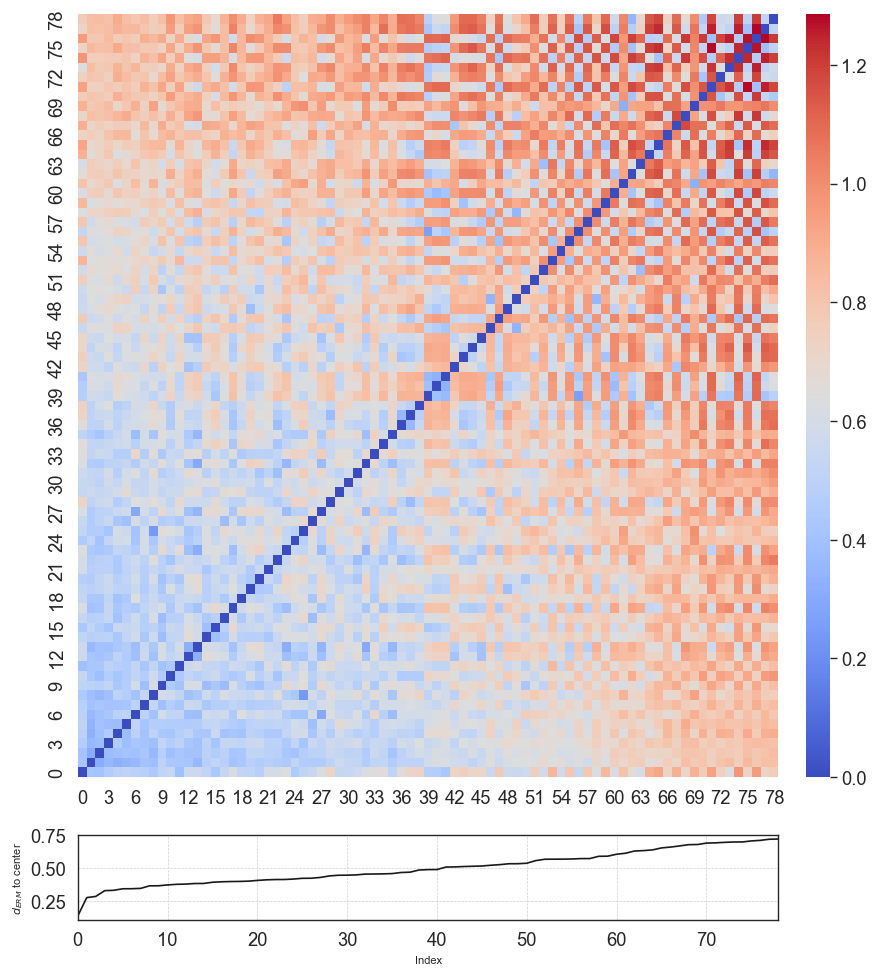

In [6]:

# fig = plt.figure(figsize=(8, 6), dpi=100)
# ax = fig.add_subplot(111)
# sns.heatmap(g_dist_mat,ax=ax, cmap='crest_r')
# ax.invert_yaxis()
# # ax.set_xticks([])
# # ax.set_yticks([])
# g_dist_center = np.mean(g_dist_mat, axis=0)


fig = plt.figure(figsize=(9, 10), dpi=100)
gs = gridspec.GridSpec(2, 2, height_ratios=[9, 1], width_ratios=[30, 1])
# The first subplot (standard deviation line plot).
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column
ax2 = fig.add_subplot(gs[1, 0])  # Second row, first column
cbar_ax = fig.add_subplot(gs[0, 1])  # Span both rows, second column

sns.heatmap(g_dist_mat,ax=ax1, cmap='coolwarm',cbar_ax=cbar_ax)
# CS = ax1.contour(g_dist_mat, colors='black', levels=20, linewidths=0.5)

ax2.plot(g_dist_to_frechet, 'k')  # 'k' is the color black for the line plot
ax2.grid(linewidth=0.5, linestyle='--', alpha=0.9)
ax2.set_ylabel('$d_{ERM}$ to center', fontsize=8)
ax2.set_xlabel('Index', fontsize=8)
ax2.autoscale(enable=True, axis='x', tight=True)
# Adding contour labels
# ax1.clabel(CS, inline=True, fontsize=8)
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

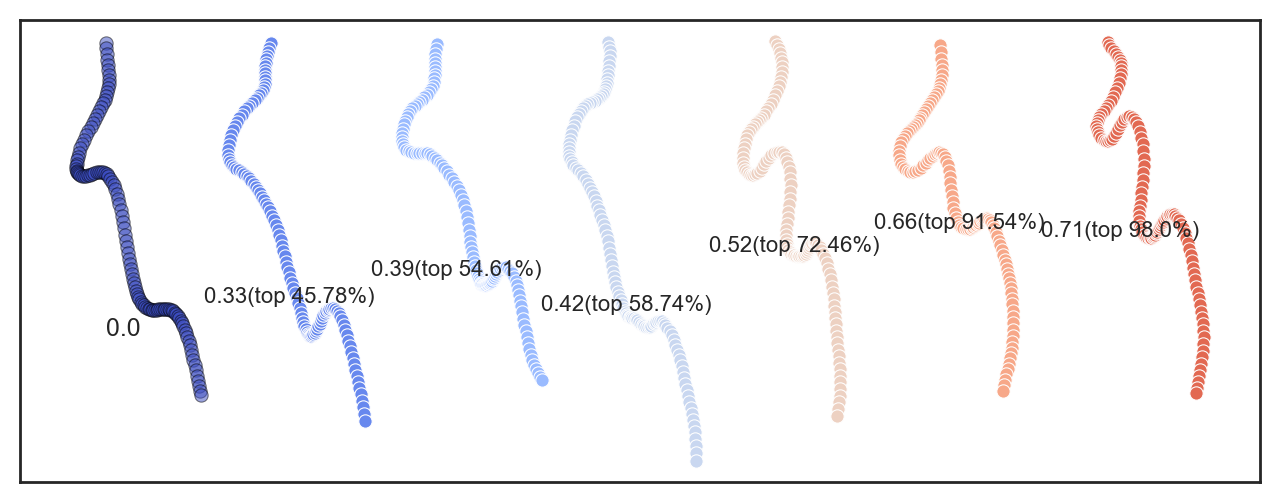

In [7]:
color_palette_1 = sns.color_palette("coolwarm", as_cmap=True)

fig = plt.figure(figsize=(8, 3), dpi=200)
ax = fig.add_subplot(111)
example_idx = [3, 15, 25, 46, 66,75]
g_dist_examples = g_dist_to_frechet[example_idx]
sns.scatterplot(x=mean_estimate[:,2]*1.2,y=mean_estimate[:,1]*1.2, color=color_palette_1(0), ax=ax, alpha=0.5,edgecolor='black')
plt.text(mean_estimate[0,2],mean_estimate[-1,1],'0.0', fontsize=9)
for i in range(len(example_idx)):
    idx = example_idx[i]
    sns.scatterplot(x=curve_bs[idx,:,2]+(i+1)*0.5,y=curve_bs[idx,:,1],  alpha=1, color = color_palette_1((i+1)/(len(example_idx)+1)), ax=ax)
    plt.text(curve_bs[idx,0,2]-0.2+(i+1)*0.5,curve_bs[idx,-50,1],str(round(g_dist_examples[i],2))+"(top {}%)".format(round(g_dist_examples[i]/np.max(g_dist_to_frechet)*100,2)), fontsize=8)

ax.set_yticks([])
ax.set_xticks([])
plt.show()



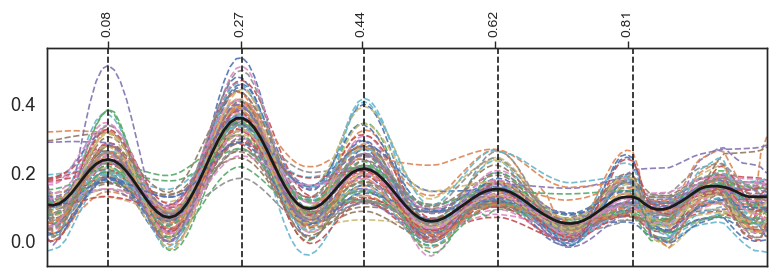

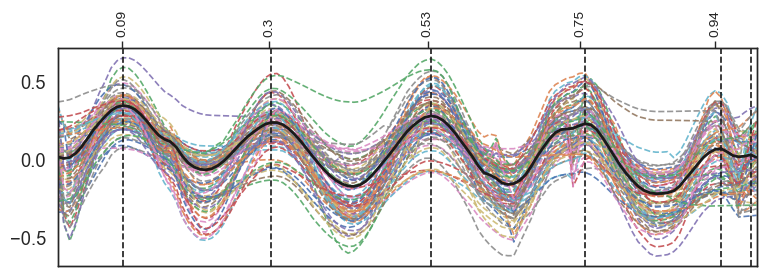

In [8]:
from scipy.signal import find_peaks

def align_curvature(curvatures,MaxItr=100):
    time = np.linspace(0, 1, len(curvatures[0]))  # 时间点
    f = curvatures.copy().T  # 数据
    # f = sample_c.T
    obj_curvature = fs.fdawarp(f,time)
    # 执行对齐
    obj_curvature.srsf_align(parallel=True, MaxItr=MaxItr)
    return obj_curvature

def set_x_ticks_normalized(ax,x_array,num=5):
    ax.set_xlim(0, len(x_array) - 1)
    ax.set_xticks(np.linspace(0, len(x_array)-1, num=num))
    ax.set_xticklabels(['{:.2f}'.format(x) for x in np.linspace(0, 1, num=num)])
    ax.autoscale(enable=True, axis='x', tight=True)

color_list_hex = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']


fig = plt.figure(figsize=(8,3), dpi=100)
ax = fig.add_subplot(111)
for i in range(obj_curvature.fn.shape[1]):
    sns.lineplot(x=range(len(curvatures[0])), y=obj_curvature.fn[:,i], alpha=0.9, ax=ax, linestyle='--')
sns.lineplot(x=range(len(curvatures[0])), y=obj_curvature.fmean, alpha=1, ax=ax, c='k', linewidth=2)

peak_indices, _ = find_peaks(obj_curvature.fmean, height=0)
for peak_index in peak_indices[:-1]:
    p_len = round(peak_index/len(curvatures[0]),2)
    ax.axvline(x=peak_index, c='k', linestyle='--')


curvature_peak_index = peak_indices.copy()
curvature_intensity_mean = obj_curvature.fmean[curvature_peak_index]



ax2 = ax.twiny()
ax2.set_xticks(peak_indices[:5]/len(curvatures[0]))
ax2.set_xticklabels([str(round(index/len(curvatures[0]),2)) for index in peak_indices[:5]], rotation=90, fontsize=10)

# set_x_ticks_normalized(ax,curvatures[0],2)
ax.set_xticks([])
ax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()

fig = plt.figure(figsize=(8,3), dpi=100)
ax = fig.add_subplot(111)
for i in range(obj_curvature.fn.shape[1]):
    sns.lineplot(x=range(len(curvatures[0])), y=obj_torsion.fn[:,i], alpha=0.9, ax=ax, linestyle='--')
sns.lineplot(x=range(len(curvatures[0])), y=obj_torsion.fmean, alpha=1, ax=ax, c='k', linewidth=2)
# for i in range(5):
#     ax.text(c_peak_indices[i], 0.5, str(round(c_peak_indices[i]/len(curvatures[0]),2)), fontsize=12)
peak_indices, _ = find_peaks(obj_torsion.fmean, height=0)
for peak_index in peak_indices:
    p_len = round(peak_index/len(curvatures[0]),2)
    ax.axvline(x=peak_index, c='k', linestyle='--')

torsion_peak_index = peak_indices.copy()
torsion_intensity_mean = obj_torsion.fmean[torsion_peak_index]
ax2 = ax.twiny()
ax2.set_xticks(peak_indices[:5]/len(curvatures[0]))
ax2.set_xticklabels([str(round(index/len(curvatures[0]),2)) for index in peak_indices[:5]], rotation=90, fontsize=10)

# set_x_ticks_normalized(ax,curvatures[0],2)
ax.set_xticks([])
ax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()



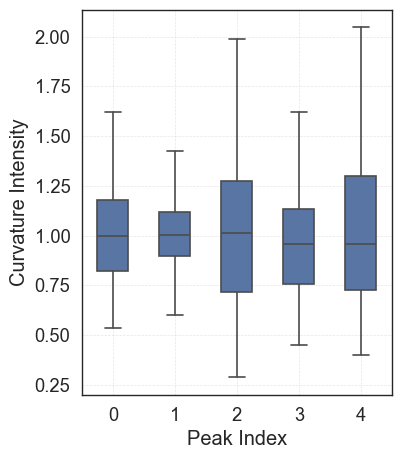

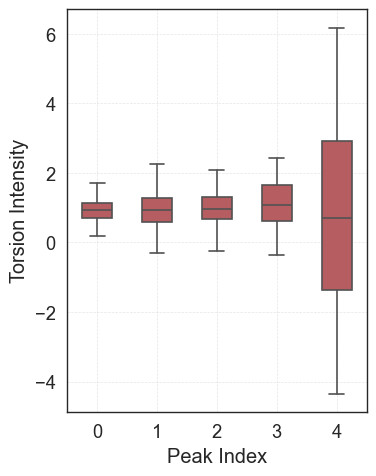

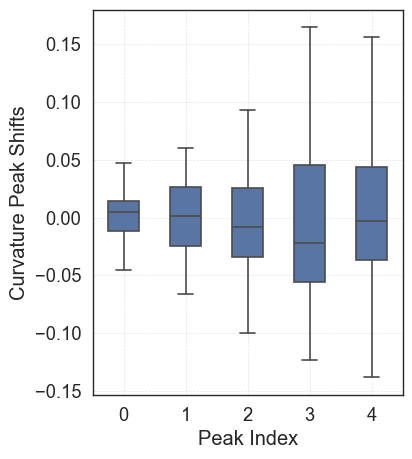

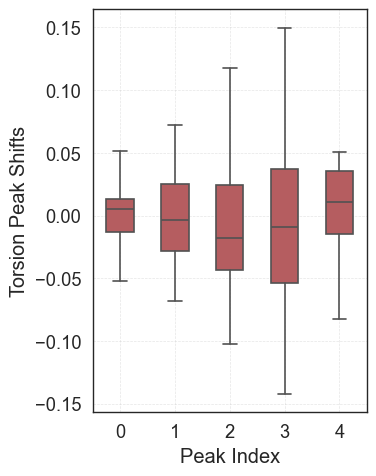

In [9]:
import pandas as pd

example_indices = [60,5,53]

fig1 = plt.figure(figsize=(4,5), dpi=100)
fig2 = plt.figure(figsize=(4,5), dpi=100)
ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)

# # Drawing boxplots for curvature peak values
# for i in range(len(c_peak_values)):
#     ax1.scatter(range(5), c_peak_values[i], alpha=0.3, marker='x', c='k')
#     ax2.scatter(range(5), t_peak_values[i], alpha=0.3, marker='x', c='k')

sns.boxplot(data=c_peak_values_transposed, ax=ax1, color='b', boxprops=dict(alpha=1),width=0.5,showfliers=False)
sns.boxplot(data=t_peak_values_transposed, ax=ax2, color='r', boxprops=dict(alpha=1),width=0.5,showfliers=False)


# for i in range(len(example_indices)):
#     ax1.scatter(range(5), c_peak_values[example_indices[i]])
#     ax2.scatter(range(5), t_peak_values[example_indices[i]])

# ax1.set_title('Curvature Intensity')
ax1.set_xlabel('Peak Index')
ax1.set_ylabel('Curvature Intensity')
# ax1.set_ylim(0,1)

# ax2.set_title('Torsion Intensity')
ax2.set_xlabel('Peak Index')
ax2.set_ylabel('Torsion Intensity')
# ax2.set_ylim(-1,1)
ax1.grid(linewidth=0.5, linestyle='--', alpha=0.5)
ax2.grid(linewidth=0.5, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


fig1 = plt.figure(figsize=(4, 5), dpi=100)
fig2 = plt.figure(figsize=(4, 5), dpi=100)
ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)
sns.boxplot(data=c_peak_movement, ax=ax1, color='b', boxprops=dict(alpha=1),width=0.5,showfliers=False)
sns.boxplot(data=t_peak_movement, ax=ax2, color='r', boxprops=dict(alpha=1),width=0.5,showfliers=False)

# for i in range(len(example_indices)):
#     ax1.scatter(range(5), c_peak_movement[example_indices[i]])
#     ax2.scatter(range(5), t_peak_movement[example_indices[i]])
# ax1.set_title('Curvature Peak Shifts')
ax1.set_xlabel('Peak Index')
ax1.set_ylabel('Curvature Peak Shifts')
# ax1.set_ylim(-1,1)
# ax2.set_title('Torsion Peak Shifts')
ax2.set_xlabel('Peak Index')
ax2.set_ylabel('Torsion Peak Shifts')
# ax2.set_ylim(-1,1)
ax1.grid(linewidth=0.5, linestyle='--', alpha=0.5)
ax2.grid(linewidth=0.5, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# print (c_peak_movement)

df_c_peak_values = pd.DataFrame(c_peak_values_transposed)
df_t_peak_values = pd.DataFrame(t_peak_values_transposed)
df_c_peak_movement = pd.DataFrame(c_peak_movement)
df_t_peak_movement = pd.DataFrame(t_peak_movement)
df_c_peak_movement.to_csv('curvature_peak_movement.csv')
df_t_peak_movement.to_csv('torsion_peak_movement.csv')
df_c_peak_values.to_csv('curvature_peak_values.csv')
df_t_peak_values.to_csv('torsion_peak_values.csv')

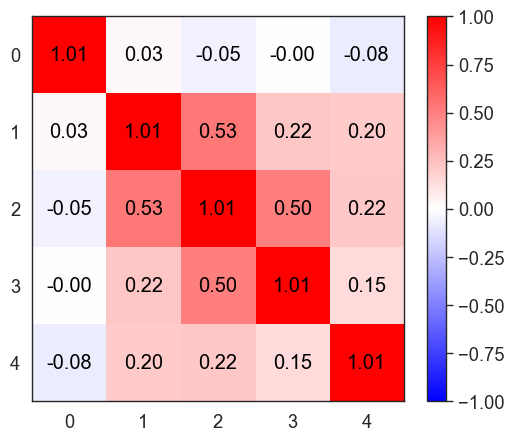

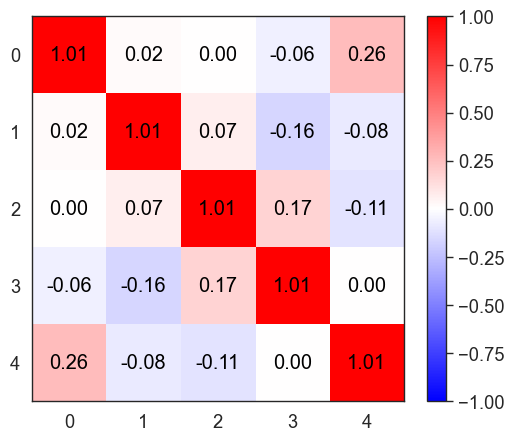

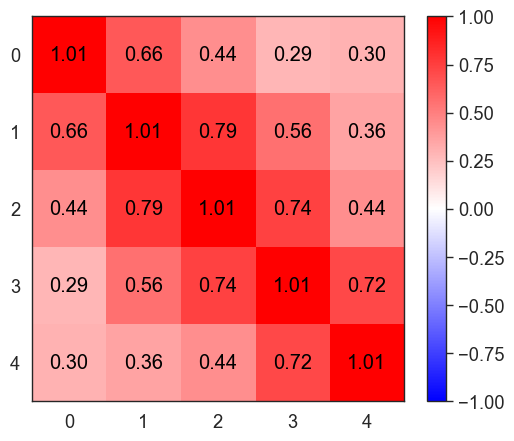

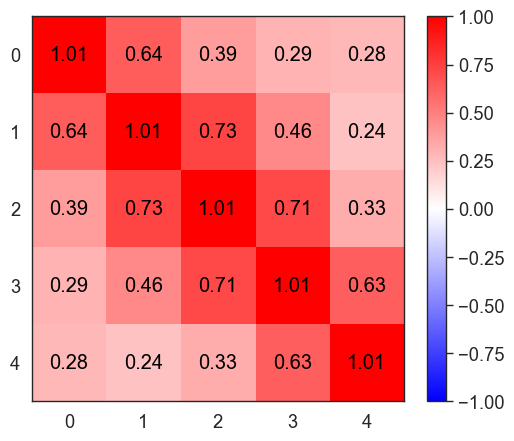

In [10]:
def plot_with_imshow(matrix, title):
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.imshow(matrix, cmap='bwr', aspect='auto',vmin=-1, vmax=1)

    # 在每个格子上标注数值，精确到小数点后两位
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='black')

    # plt.title(title)
    plt.colorbar(cax)
    plt.grid(False)
    plt.show()
    return matrix

# 计算自协方差矩阵
c_autocovariance_values = autocovariance_function(min_max_normalize(np.array(c_peak_values)))
t_autocovariance_values = autocovariance_function(min_max_normalize(np.array(t_peak_values)))
c_movement_autocovariance_values = autocovariance_function(min_max_normalize(c_peak_movement))
t_movement_autocovariance_values = autocovariance_function(min_max_normalize(t_peak_movement))

# 可视化自协方差矩阵
mat_c = plot_with_imshow(c_autocovariance_values, 'Curvature Autocovariance Matrix')
mat_t = plot_with_imshow(t_autocovariance_values, 'Torsion Autocovariance Matrix')
mat_c_movement = plot_with_imshow(c_movement_autocovariance_values, 'Curvature Movement Autocovariance Matrix')
mat_t_movement = plot_with_imshow(t_movement_autocovariance_values, 'Torsion Movement Autocovariance Matrix')


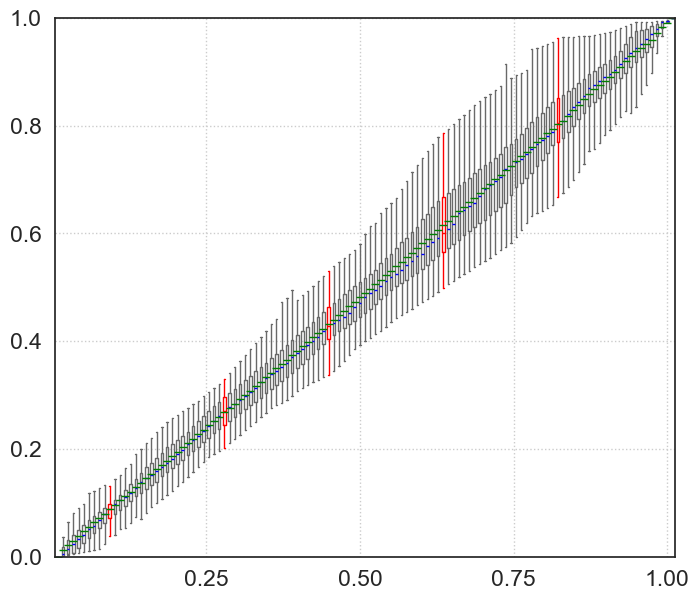

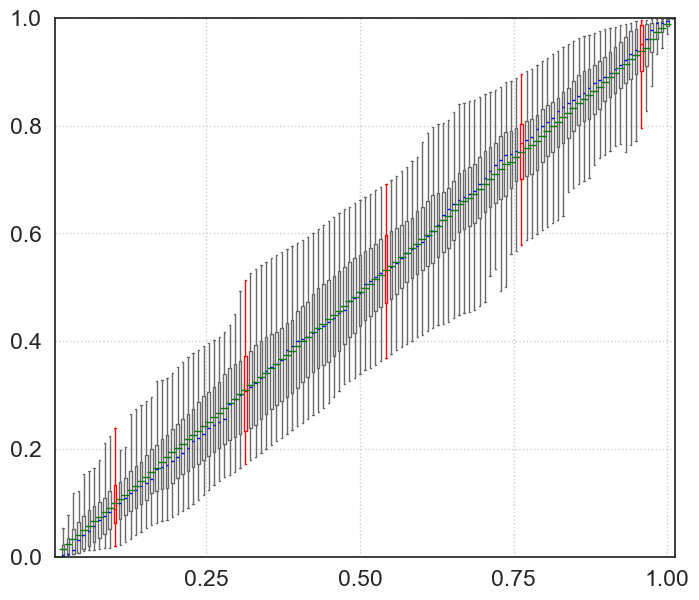

In [11]:
meanprops = {
    "marker": "_",
    "markeredgecolor": "green",
    "markerfacecolor": "green",
    # "markersize": 25
}

sns.set_context("notebook", font_scale=1.5)

for obj, peak_indices in zip([obj_curvature, obj_torsion], [c_peak_indices, t_peak_indices]):

    fig = plt.figure(figsize=(8,7), dpi=100, facecolor='w')
    ax = fig.add_subplot(111)
    boxprops = {'color': 'dimgray', 'linewidth': 1}
    medianprops = {'color': 'blue', 'linewidth': 1}
    bp = ax.boxplot(obj.gam.T, showmeans=True, showfliers=False, medianprops=medianprops, meanprops=meanprops, boxprops=boxprops, whiskerprops=boxprops, capprops=boxprops)

    for peak in peak_indices:
        # Change the color of the boxplot elements at the peak indices
        plt.setp(bp['boxes'][peak], color='red')
        plt.setp(bp['whiskers'][2*peak], color='red')
        plt.setp(bp['whiskers'][2*peak + 1], color='red')
        plt.setp(bp['caps'][2*peak], color='red')
        plt.setp(bp['caps'][2*peak + 1], color='red')
        plt.setp(bp['medians'][peak], color='red')

    # ax.plot([0, 120], [0, 1], linestyle=':', color='k', alpha=0.5, linewidth=3)
    # for peak in peak_indices:
    #     ax.axvline(x=peak, c='k', linewidth=3, alpha=0.5)
    
    set_x_ticks_normalized(ax, obj.gam)
    ax.autoscale(enable=True, axis='y', tight=True)
    ax.grid(linewidth=1, linestyle=':', alpha=1)
    plt.show()

显然并不需要说fPCA,只需要讲srsf对齐.
对齐后根据warping function查看伸缩情况即可.

In [12]:
vpca_curvature = fs.fdavpca(obj_curvature)
vpca_curvature.calc_fpca(no=3)
hpca_curvature = fs.fdahpca(obj_curvature)
hpca_curvature.calc_fpca(no=3)
jpca_curvature = fs.fdajpca(obj_curvature)
jpca_curvature.calc_fpca(no=3)

vpca_torsion = fs.fdavpca(obj_torsion)
vpca_torsion.calc_fpca(no=3)
hpca_torsion = fs.fdahpca(obj_torsion)
hpca_torsion.calc_fpca(no=3)
jpca_torsion = fs.fdajpca(obj_torsion)
jpca_torsion.calc_fpca(no=3)


In [13]:
from scipy.spatial.transform import Rotation as R

def random_transform_curve(curve_cs):
    # Copy the array to avoid modifying the original
    transformed_curves = np.copy(curve_cs)
    
    for i in range(curve_cs.shape[0]):
        # Generate a random rotation
        rotation = R.from_euler('xyz', np.random.uniform(0, 360, 3), degrees=True)
        
        # Generate a random scale factor between 0.9 and 1.1
        scale_factor = np.random.uniform(0.9, 1.1)
        
        # Apply the rotation and scale to each point in the curve
        transformed_curves[i] = rotation.apply(curve_cs[i]) * scale_factor
    
    return transformed_curves

translate_curve = random_transform_curve(curve_cs)

pca = PCA(n_components=16)

standard_coordinate = StandardScaler().fit_transform(translate_curve.reshape(len(curve_cs),-1))
# print (standard_coordinate.shape)
results = pca.fit_transform(standard_coordinate)
# print (pca.explained_variance_ratio_)

# sns.set_context('notebook', font_scale=1.2)
# fig = plt.figure(figsize=(8, 7), dpi=100)
# ax = fig.add_subplot(111)
# ax.scatter(results[:,0],results[:,1],c=g_dist_to_frechet, cmap='coolwarm', edgecolor='black', s=50)
# ax.grid(linestyle='--', alpha=0.6)
# ax.set_xlabel('PCA1')
# ax.set_ylabel('PCA2')
# plt.show()

# Calculating the statistics
mean_values = np.mean(results[:,:5], axis=0)
std_values = np.std(results[:,:5], axis=0)
max_values = np.max(results[:,:5], axis=0)
min_values = np.min(results[:,:5], axis=0)

# Creating a DataFrame
data = {
    # "Mean": mean_values,
    "Std Dev": std_values,
    "Max": max_values,
    "Min": min_values
}

df = pd.DataFrame(data)
df


Std Dev        Max        Min
0  10.409866  18.891195 -17.672496
1   9.470733  17.791872 -17.540291
2   8.765106  19.974519 -15.539846
3   5.136869  11.279494  -8.737345
4   4.420695   9.406124  -8.084883

In [14]:
from scipy.ndimage import gaussian_filter
sns.set_context('notebook', font_scale=1.2)
tPCA_N_COMPONENTS = 16

tpca = TangentPCA(curves_r3, n_components=tPCA_N_COMPONENTS)
tpca.fit(curve_cs, base_point=tangent_base)
tangent_projected_data = tpca.transform(curve_cs)

# print (tangent_projected_data.shape)
# # 步骤4: 分析和可视化结果
# sns.set_context('notebook', font_scale=1.2)
# fig = plt.figure(figsize=(7, 6))
# ax1 = fig.add_subplot(111)
# sns.scatterplot(x=tangent_projected_data[:, 0], y=tangent_projected_data[:, 1], edgecolor='black',c=g_dist_to_frechet,ax=ax1, cmap='coolwarm',s=50)
# ax1.grid(linestyle='--', alpha=0.6 )
# ax1.set_xlabel('MoD1')
# ax1.set_ylabel('MoD2')
# ax1.autoscale(enable=True, axis='x', tight=False)
# plt.tight_layout()
# tpca.explained_variance_ratio_


std_values = np.std(tangent_projected_data,axis=0)
max_values = np.max(tangent_projected_data,axis=0)
min_values = np.min(tangent_projected_data,axis=0)

# Create a DataFrame
data = {
    "std": std_values,
    "max": max_values,
    "min": min_values,
    "EV": tpca.explained_variance_ratio_,
    "CEV": np.cumsum(tpca.explained_variance_ratio_)
}

df = pd.DataFrame(data)
df_rounded = df.round(4)


df_rounded

std     max     min      EV     CEV
0   0.4964  1.2060 -0.9870  0.3969  0.3969
1   0.3590  1.0082 -0.6678  0.2076  0.6045
2   0.3369  0.8525 -0.7908  0.1828  0.7872
3   0.2217  0.5846 -0.4379  0.0792  0.8664
4   0.1279  0.3710 -0.2966  0.0263  0.8928
5   0.1188  0.3306 -0.2196  0.0227  0.9155
6   0.1141  0.3886 -0.3181  0.0210  0.9364
7   0.0905  0.2826 -0.1950  0.0132  0.9496
8   0.0863  0.2154 -0.2119  0.0120  0.9616
9   0.0686  0.1497 -0.1291  0.0076  0.9692
10  0.0574  0.1608 -0.1043  0.0053  0.9745
11  0.0536  0.1287 -0.1273  0.0046  0.9791
12  0.0462  0.1338 -0.1055  0.0034  0.9825
13  0.0412  0.1047 -0.0855  0.0027  0.9853
14  0.0393  0.0832 -0.0736  0.0025  0.9878
15  0.0347  0.0985 -0.0812  0.0019  0.9897

In [15]:
from scipy.spatial.distance import cosine
import random
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook', font_scale=1.2)
# Step 1: First Dataset (Tangent PCA)
coordinates_tangent = tangent_projected_data.copy()
subject_labels = []
for i in range(len(files)):
    subject_labels.append(" ".join([files[i].split('\\')[-1].split('_')[0], files[i].split('\\')[-1].split('_')[2][0]]))

tag_dict = {}
for index, label in enumerate(subject_labels):
    tag, side = label.split()
    if tag not in tag_dict:
        tag_dict[tag] = []
    tag_dict[tag].append((side, index))

# Same subject cosine distances for Tangent PCA
same_label_distances_tangent = []
for tag, pairs in tag_dict.items():
    if len(pairs) > 1:
        for i in range(len(pairs)):
            for j in range(i + 1, len(pairs)):
                coord1 = coordinates_tangent[pairs[i][1]]
                coord2 = coordinates_tangent[pairs[j][1]]
                distance = cosine(coord1, coord2)
                same_label_distances_tangent.append(distance)

# Random pair cosine distances for Tangent PCA
random_distances_tangent = []
num_pairs_tangent = len(same_label_distances_tangent)
for _ in range(num_pairs_tangent):
    idx1, idx2 = random.sample(range(len(coordinates_tangent)), 2)
    coord1 = coordinates_tangent[idx1]
    coord2 = coordinates_tangent[idx2]
    distance = cosine(coord1, coord2)
    random_distances_tangent.append(distance)

# Step 2: Second Dataset (Standard PCA)
coordinates_standard = results.copy()
subject_labels_standard = []
for i in range(len(files)):
    subject_labels_standard.append(" ".join([files[i].split('\\')[-1].split('_')[0], files[i].split('\\')[-1].split('_')[2][0]]))

tag_dict_standard = {}
for index, label in enumerate(subject_labels_standard):
    tag, side = label.split()
    if tag not in tag_dict_standard:
        tag_dict_standard[tag] = []
    tag_dict_standard[tag].append((side, index))

# Same subject cosine distances for Standard PCA
same_label_distances_standard = []
for tag, pairs in tag_dict_standard.items():
    if len(pairs) > 1:
        for i in range(len(pairs)):
            for j in range(i + 1, len(pairs)):
                coord1 = coordinates_standard[pairs[i][1]]
                coord2 = coordinates_standard[pairs[j][1]]
                distance = cosine(coord1, coord2)
                same_label_distances_standard.append(distance)

# Random pair cosine distances for Standard PCA
random_distances_standard = []
num_pairs_standard = len(same_label_distances_standard)
for _ in range(num_pairs_standard):
    idx1, idx2 = random.sample(range(len(coordinates_standard)), 2)
    coord1 = coordinates_standard[idx1]
    coord2 = coordinates_standard[idx2]
    distance = cosine(coord1, coord2)
    random_distances_standard.append(distance)



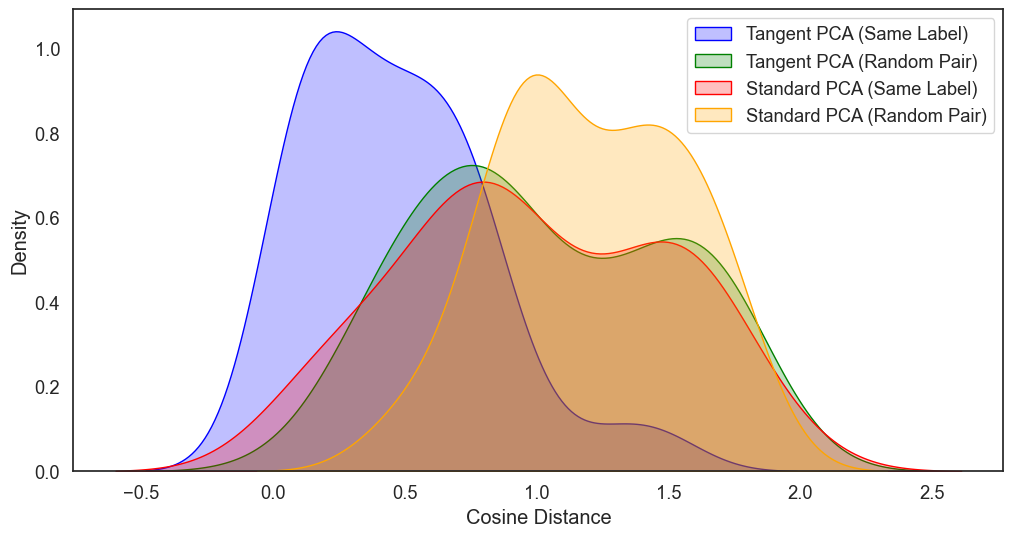

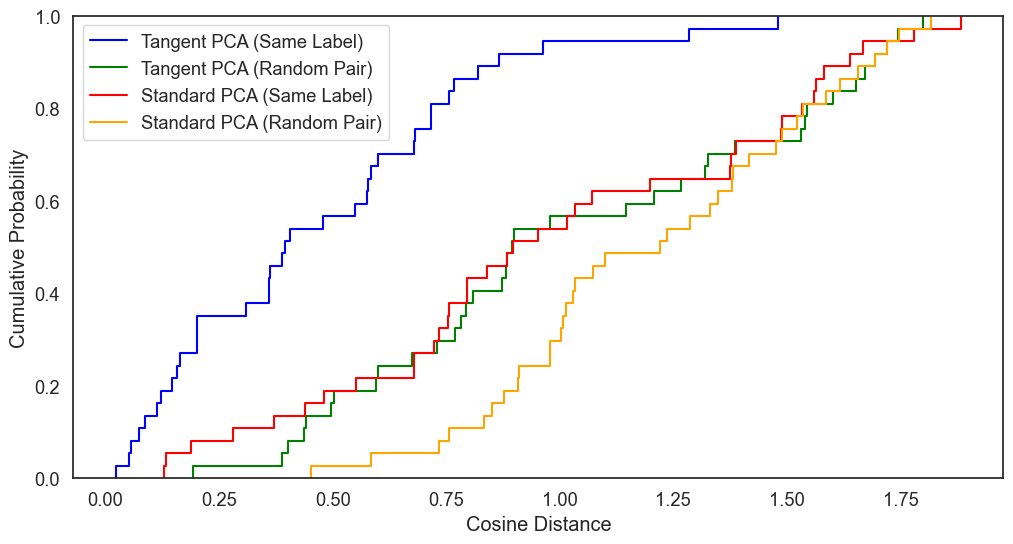

In [16]:
# Step 3: Plotting results for Tangent PCA and Standard PCA

plt.figure(figsize=(12, 6))

# Plot Tangent PCA
sns.kdeplot(same_label_distances_tangent, shade=True, label='Tangent PCA (Same Label)', color='blue')
sns.kdeplot(random_distances_tangent, shade=True, label='Tangent PCA (Random Pair)', color='green')
# Plot Standard PCA
sns.kdeplot(same_label_distances_standard, shade=True, label='Standard PCA (Same Label)', color='red')
sns.kdeplot(random_distances_standard, shade=True, label='Standard PCA (Random Pair)', color='orange')
# sns.kdeplot(same_label_distances_tangent, shade=True, label='Tangent PCA (Same Label)', color='blue', clip=(0, 2.5))
# sns.kdeplot(random_distances_tangent, shade=True, label='Tangent PCA (Random Pair)', color='green', clip=(0,  2.5))
# sns.kdeplot(same_label_distances_standard, shade=True, label='Standard PCA (Same Label)', color='red', clip=(0,  2.5))
# sns.kdeplot(random_distances_standard, shade=True, label='Standard PCA (Random Pair)', color='orange', clip=(0,  2.5))

# plt.title('Density Plot of Cosine Distances (Tangent PCA vs Standard PCA)')
plt.xlabel('Cosine Distance')
plt.ylabel('Density')
plt.legend()
plt.show()


# CDF Plot
plt.figure(figsize=(12, 6))
sns.ecdfplot(same_label_distances_tangent, label='Tangent PCA (Same Label)', color='blue')
sns.ecdfplot(random_distances_tangent, label='Tangent PCA (Random Pair)', color='green')
sns.ecdfplot(same_label_distances_standard, label='Standard PCA (Same Label)', color='red')
sns.ecdfplot(random_distances_standard, label='Standard PCA (Random Pair)', color='orange')

# plt.title('CDF of Cosine Distances (Tangent PCA vs Standard PCA)')
plt.xlabel('Cosine Distance')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()


#0 curvature peak VS 6 MoD: 0.46
#1 curvature peak VS 1 MoD: 0.36
#1 curvature peak VS 5 MoD: -0.34
#2 curvature peak VS 0 MoD: 0.40
#2 curvature peak VS 1 MoD: 0.39
#2 curvature peak VS 5 MoD: -0.47
#2 curvature peak VS 7 MoD: 0.34
#3 curvature peak VS 0 MoD: 0.36
#3 curvature peak VS 5 MoD: -0.39
#4 curvature peak VS 1 MoD: 0.47
#4 torsion peak VS 5 MoD: -0.35


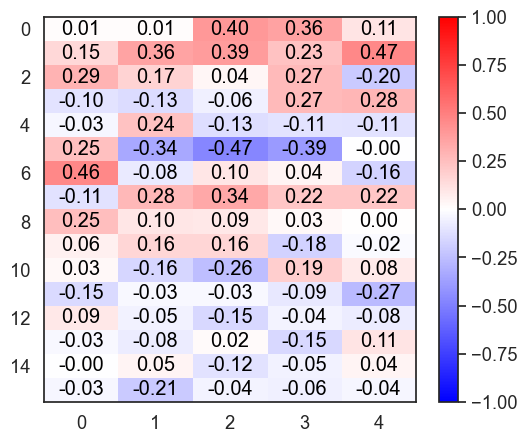

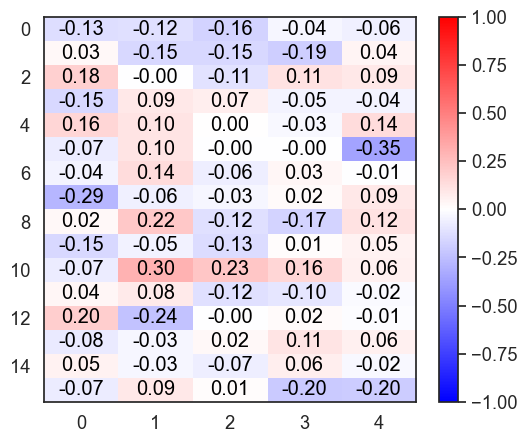

array([[-0.12865806, -0.12401926, -0.16456268, -0.03507474, -0.05811214],
       [ 0.03068926, -0.15302182, -0.14968659, -0.1893378 ,  0.03921484],
       [ 0.18495179, -0.00451919, -0.11247868,  0.11083523,  0.09331475],
       [-0.15268063,  0.09184483,  0.06598976, -0.04530883, -0.04209979],
       [ 0.16293952,  0.10178331,  0.00108666, -0.02764292,  0.14006568],
       [-0.07334396,  0.10271413, -0.00397912, -0.0007121 , -0.35277884],
       [-0.04134306,  0.14054204, -0.06485562,  0.0349496 , -0.00727748],
       [-0.28721901, -0.06087685, -0.03427875,  0.01618835,  0.0887795 ],
       [ 0.02476819,  0.21702532, -0.12338446, -0.17153904,  0.11532542],
       [-0.15245224, -0.05159824, -0.13381652,  0.01415986,  0.05282889],
       [-0.07348917,  0.29752446,  0.22617195,  0.16373232,  0.05723787],
       [ 0.03719814,  0.07930267, -0.11773585, -0.09991101, -0.0227479 ],
       [ 0.19514855, -0.23566934, -0.00427983,  0.01748154, -0.00991843],
       [-0.07850332, -0.03466875,  0.0

In [17]:
mat = np.zeros((tPCA_N_COMPONENTS,5,2))
for i in range(5):
    for j in range(tPCA_N_COMPONENTS):
        c = np.corrcoef(tangent_projected_data[:,j], c_peak_values[:,i])[0,1]
        t = np.corrcoef(tangent_projected_data[:,j], t_peak_values[:,i])[0,1]
        mat[j,i,0] = c
        mat[j,i,1] = t
        if abs(c) > 0.3:
            print ("#{} curvature peak VS {} MoD: {:.2f}".format(i,j,c))
        if abs(t) > 0.3:
            print ("#{} torsion peak VS {} MoD: {:.2f}".format(i,j,t))

plot_with_imshow(mat[:,:,0], 'Curvature Peaks Correlation')
plot_with_imshow(mat[:,:,1], 'Torsion Peaks Correlation')

In [18]:
from scipy.stats import norm


def from_tangentPCA_feature_to_curves(tpca, tangent_base, tangent_projected_data, PCA_N_COMPONENTS, discrete_curves_space):
    principal_components = tpca.components_
    # Assuming principal_components has the shape (n_components, n_sampling_points * n_dimensions)
    point_num = len(tangent_base)
    principal_components_reshaped = principal_components.reshape((PCA_N_COMPONENTS, point_num, 3)) # point_num是采样点数
    # Now use exp on each reshaped component
    curves_from_components = [
        discrete_curves_space.metric.exp(tangent_vec=component, base_point=tangent_base)
        for component in principal_components_reshaped
    ]

    reconstructed_curves = []
    for idx in range(len(tangent_projected_data)):
        # This is your feature - a single point in PCA space representing the loadings for the first curve.
        feature = np.array(tangent_projected_data[idx])
        # Reconstruct the tangent vector from the feature.
        # print ("feature:", feature.shape)
        # print ("principal_components_reshaped:", principal_components_reshaped.shape)
        # print ("idx:", idx)
        tangent_vector_reconstructed = sum(feature[i] * principal_components_reshaped[i] for i in range(len(feature)))
        # Map the tangent vector back to the curve space using the exponential map.
        reconstructed_curve = discrete_curves_space.metric.exp(
            tangent_vec=tangent_vector_reconstructed, base_point=tangent_base
        )
        # reconstructed_curve = inverse_srvf(reconstructed_srvf, np.zeros(3))
        # print ("reconstructed_curve length:", measure_length(reconstructed_curve))# length=63
        
        reconstructed_curves.append(reconstructed_curve)
    reconstructed_curves = np.array(reconstructed_curves)
    return reconstructed_curves

discrete_curves_space = curves_r3
print (tPCA_N_COMPONENTS)
reconstructed_curves = from_tangentPCA_feature_to_curves(tpca, tangent_base, tangent_projected_data, 
                                                                              tPCA_N_COMPONENTS, 
                                                                              discrete_curves_space)

total_l2d = []
for curve_idx in range(79):
    l2d = []
    # for i in [1,2,3,5,10,15]:
    for i in range(tPCA_N_COMPONENTS):
        ft = tangent_projected_data[curve_idx,:].copy()
        # print (ft.shape)
        ft[i:] = 0
        reconstructed_step_curve = from_tangentPCA_feature_to_curves(tpca, tangent_base, np.array([ft]), 
                                                                                    tPCA_N_COMPONENTS, 
                                                                                    discrete_curves_space)[0]
        least_squares_error = curves_r3.metric.dist(curve_cs[curve_idx], reconstructed_step_curve)
        l2d.append(least_squares_error)
    total_l2d.append(l2d)


16


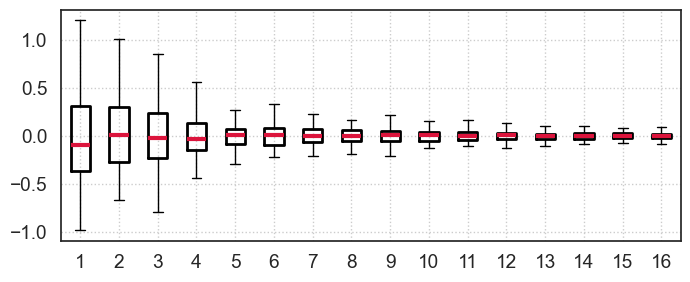

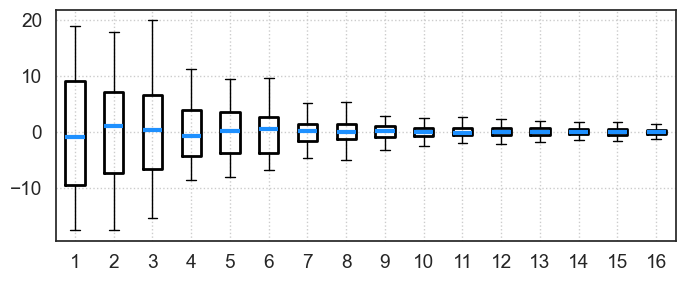

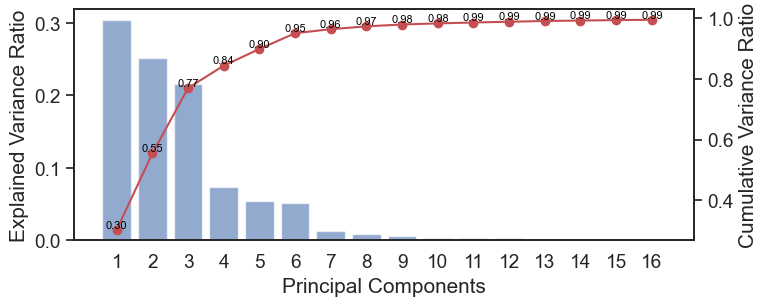

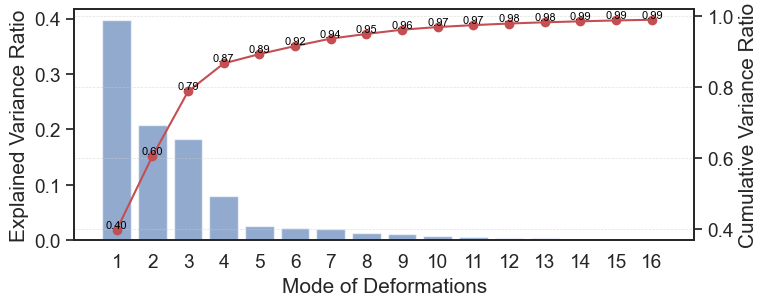

In [19]:
sns.set_context('notebook', font_scale=1.25)

fig = plt.figure(figsize=(8, 3), dpi=100)
ax = fig.add_subplot(111)
ax.boxplot(tangent_projected_data, showfliers=False, medianprops={'color': 'crimson', 'linewidth': 3},boxprops={'color': 'black', 'linewidth': 2})
ax.grid(linewidth=1, linestyle=':', alpha=1)
plt.show()

fig = plt.figure(figsize=(8, 3), dpi=100)
ax = fig.add_subplot(111)
ax.boxplot(results, showfliers=False, medianprops={'color': 'dodgerblue', 'linewidth': 3},boxprops={'color': 'black', 'linewidth': 2})
ax.grid(linewidth=1, linestyle=':', alpha=1)
plt.show()


# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 3), dpi=100, facecolor='w')

# Bar plot for explained variance ratio
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, label='Explained Variance Ratio')
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_xticks(range(1, len(explained_variance_ratio) + 1))

# Line plot for cumulative variance ratio
ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'r-', marker='o', label='Cumulative Variance Ratio')
# Adding height annotations
for i, val in enumerate(cumulative_variance_ratio):
    ax2.text(i + 1, val, f'{val:.2f}', ha='center', va='bottom', fontsize=8, color='black')
ax2.set_ylabel('Cumulative Variance Ratio')

# # Adding legends
# fig.legend()

# plt.title('Explained Variance Ratio and Cumulative Variance Ratio')
plt.show()


# Explained variance ratio
explained_variance_ratio = tpca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
# Plotting
fig, ax1 = plt.subplots(figsize=(8, 3), dpi=100, facecolor='w')

# Bar plot for explained variance ratio
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, label='Explained Variance Ratio')
ax1.set_xlabel('Mode of Deformations')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_xticks(range(1, len(explained_variance_ratio) + 1))

# Line plot for cumulative variance ratio
ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'r-', marker='o', label='Cumulative Variance Ratio')
# Adding height annotations
for i, val in enumerate(cumulative_variance_ratio):
    ax2.text(i + 1, val, f'{val:.2f}', ha='center', va='bottom', fontsize=8, color='black')

ax2.set_ylabel('Cumulative Variance Ratio')

# # Adding legends
# fig.legend()

# plt.title('Explained Variance Ratio and Cumulative Variance Ratio')
ax2.grid(linestyle='--', alpha=0.6, linewidth=0.5)
plt.show()


(16,)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23972217160245815, 0.23972217160245815, 0.2656752067595596, 0.2656752067595596, 0.2942433567420146, 0.2942433567420146, 0.29991396808997084, 0.29991396808997084, 0.3086550214668495, 0.3086550214668495, 0.312658799759599, 0.312658799759599, 0.3185657032088423, 0.3185657032088423, 0.3240627944458835, 0.3240627944458835, 0.3252840015734353, 0.3252840015734353, 0.33394575440891355, 0.33394575440891355, 0.3366347620723955, 0.3366347620723955, 0.3412124156585592, 0.3412124156585592, 0.34504703672256226, 0.34504703672256226, 0.35000616136344476, 0.35000616136344476, 0.3527652519786433, 0.35276525

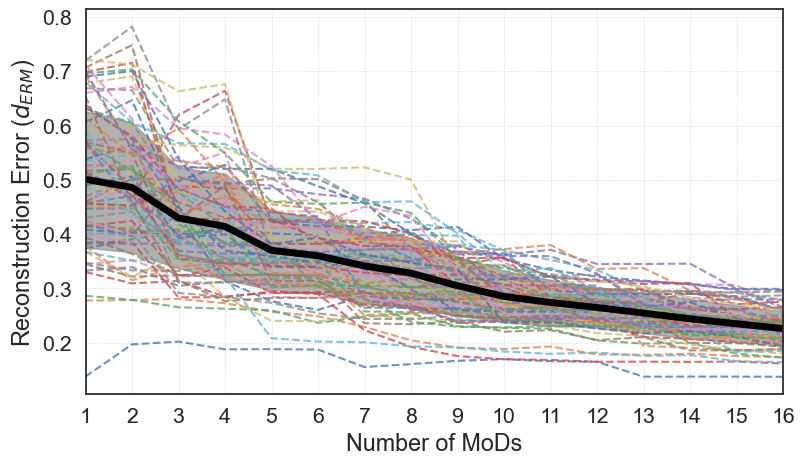

In [20]:
sns.set_context('notebook', font_scale=1.4)

total_l2d = np.array(total_l2d)
mean_l2d = np.mean(total_l2d, axis=0)
std_l2d = np.std(total_l2d, axis=0)
print (np.mean(total_l2d,axis=0).shape)

fig = plt.figure(figsize=(9, 5), dpi=100)
ax = fig.add_subplot(111)

# 绘制标准差带
ax.fill_between(range(len(mean_l2d)), mean_l2d - std_l2d, mean_l2d + std_l2d, color='gray', alpha=0.6)
for i in range(79):
    ax.plot(total_l2d[i],linestyle='--', alpha=0.8, linewidth=1.5)
ax .plot(np.mean(total_l2d,axis=0),linestyle='-', color='black', linewidth=5)
ax.autoscale(enable=True, axis='x', tight=True)

# 获取当前x轴的刻度位置（默认是从0开始）并加1来变成从1开始
ticks = np.arange(len(mean_l2d))  # 生成从0到len(mean_l2d)-1的整数数组
ax.set_xticks(ticks)  # 设置x轴的刻度位置
ax.set_xticklabels(ticks + 1)  # 设置x轴的刻度标签，从1开始
ax.set_xlabel('Number of MoDs')
ax.set_ylabel('Reconstruction Error ($d_{ERM}$)')
ax.grid(linestyle='--', alpha=0.6, linewidth=0.5)
print (sorted(g_dist_mat.flatten()))

In [36]:
def save_vtk_text(filename, all_points, num_components, component_values):
    with open(filename, 'w') as f:
        # Write the header
        f.write("# vtk DataFile Version 2.0\n")
        f.write("3D curve data\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")

        # Write the points
        total_points = sum(len(points) for points in all_points)
        f.write(f"POINTS {total_points} float\n")
        point_offset = 0
        for points in all_points:
            for point in points:
                f.write(f"{point[0]} {point[1]} {point[2]}\n")

        # Write the lines
        f.write(f"LINES {num_components} {total_points + num_components}\n")
        point_index = 0
        for points in all_points:
            f.write(f"{len(points)} ")
            for i in range(len(points)):
                f.write(f"{point_index + i} ")
            f.write("\n")
            point_index += len(points)
        # Write the cell data
        f.write(f"CELL_DATA {num_components}\n")
        f.write("SCALARS ComponentValue float 1\n")
        f.write("LOOKUP_TABLE default\n")
        for value in component_values:
            f.write(f"{value+1}\n")

# 08.09 comment out
# for curve_idx in [60, 5, 53]:
#     all_points = []
#     component_values = []
#     for i in range(tPCA_N_COMPONENTS):
#         ft = tangent_projected_data[curve_idx, :].copy()
#         ft[i:] = 0
#         ft[i] = ft[i] *  np.random.uniform(-1.5, 1.5)
#         reconstructed_step_curve = from_tangentPCA_feature_to_curves(tpca, tangent_base, np.array([ft]), 
#                                                                       tPCA_N_COMPONENTS, 
#                                                                       discrete_curves_space)[0]
#         # Adjust the z-coordinate to separate the curves
#         points = reconstructed_step_curve[:, [2, 1, 0]]*2.5  # Adjust the order of columns if necessary
#         points[:, 0] += i * 0.5
#         all_points.append(points)
#         component_values.append(i)
#     filename = f'curve_{curve_idx}_magic.vtk'
#     print(f'Saving {filename}')
    # save_vtk_text(filename, all_points, tPCA_N_COMPONENTS, component_values)


# 9.13 comment Out
# base_curve = np.mean(tangent_projected_data, axis=0)
# sigma = np.std(tangent_projected_data, axis=0)
# print (base_curve.shape, sigma.shape)
# times = np.linspace(-3,3,15)
# synthetic_curves_by_component = []
# for i in range(tPCA_N_COMPONENTS):
#     # synthetic_c = []
#     all_points = []
#     component_values = []
#     for t in times:
#         ft = base_curve.copy()
#         ft[i] = ft[i] + t * sigma[i]
#         reconstructed_step_curve = from_tangentPCA_feature_to_curves(tpca, tangent_base, np.array([ft]), 
#                                                                       tPCA_N_COMPONENTS, 
#                                                                       discrete_curves_space)[0]
#         # Adjust the z-coordinate to separate the curves
#         points = reconstructed_step_curve[:, [2, 1, 0]]*2.5  # Adjust the order of columns if necessary
#         points[:, 0] += t * 0.5
#         all_points.append(points)

#         component_values.append(t)
#     synthetic_curves_by_component.append(all_points)
#     filename = f'deformation_{i}.vtk'
#     print(f'Saving {filename}')
#     # save_vtk_text(filename, all_points, len(times), component_values)


(16,) (16,)
Saving deformation_0.vtk
Saving deformation_1.vtk
Saving deformation_2.vtk
Saving deformation_3.vtk
Saving deformation_4.vtk
Saving deformation_5.vtk
Saving deformation_6.vtk
Saving deformation_7.vtk
Saving deformation_8.vtk
Saving deformation_9.vtk
Saving deformation_10.vtk
Saving deformation_11.vtk
Saving deformation_12.vtk
Saving deformation_13.vtk
Saving deformation_14.vtk
Saving deformation_15.vtk


In [43]:
base_curve = np.mean(tangent_projected_data, axis=0)
sigma = np.std(tangent_projected_data, axis=0)
print(base_curve.shape, sigma.shape)
times = np.linspace(-3, 3, 15)  # 曲线的数量
synthetic_curves_by_component = []

# 用来记录第一条曲线的 y 方向高度
first_curve_y_range = None

# 计算等距的 x 轴偏移量
x_offsets = np.linspace(0, len(times) * 0.25, len(times))  # 生成等距的 x 轴偏移

for i in range(tPCA_N_COMPONENTS):
    all_points = []
    component_values = []
    
    for idx, t in enumerate(times):
        ft = base_curve.copy()
        ft[i] = ft[i] + t * sigma[i]
        
        # Reconstruct the curve
        reconstructed_step_curve = from_tangentPCA_feature_to_curves(tpca, tangent_base, np.array([ft]), 
                                                                      tPCA_N_COMPONENTS, 
                                                                      discrete_curves_space)[0]
        
        # Adjust the z-coordinate to separate the curves (assuming z is the 0th column)
        points = reconstructed_step_curve[:, [2, 1, 0]] * 2.5  # Adjust the order if necessary
        
        # 获取当前曲线的 y 坐标的最大值和最小值
        y_max = np.max(points[:, 1])
        y_min = np.min(points[:, 1])
        y_range = y_max - y_min

        if first_curve_y_range is None:
            # 如果是第一条曲线，记录它的 y 方向高度
            first_curve_y_range = y_range
        else:
            # 对其他曲线进行均匀缩放
            scale_factor = first_curve_y_range / y_range
            points *= scale_factor  # 对 x, y, z 坐标进行均匀缩放

        # 根据计算的等距偏移量移动曲线的第一个点在 x 轴方向上的位置
        points[:, 0] += x_offsets[idx]  # 使用等距偏移量
        
        all_points.append(points)
        component_values.append(t)
    
    synthetic_curves_by_component.append(all_points)
    
    # Save the results
    filename = f'deformation_{i}.vtk'
    print(f'Saving {filename}')
    save_vtk_text(filename, all_points, len(times), component_values)


(16,) (16,)
Saving deformation_0.vtk
Saving deformation_1.vtk
Saving deformation_2.vtk
Saving deformation_3.vtk
Saving deformation_4.vtk
Saving deformation_5.vtk
Saving deformation_6.vtk
Saving deformation_7.vtk
Saving deformation_8.vtk
Saving deformation_9.vtk
Saving deformation_10.vtk
Saving deformation_11.vtk
Saving deformation_12.vtk
Saving deformation_13.vtk
Saving deformation_14.vtk
Saving deformation_15.vtk


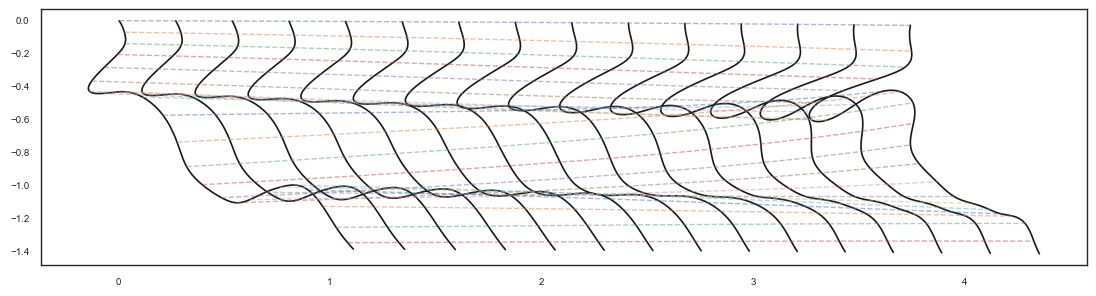

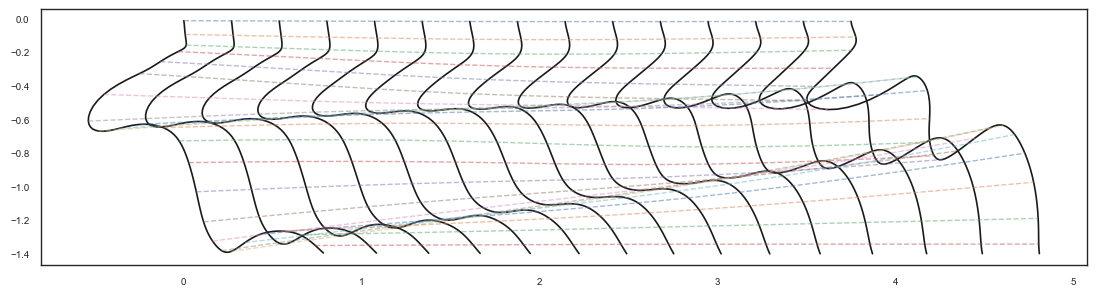

In [58]:
base_curve = np.mean(tangent_projected_data, axis=0)
sigma = np.std(tangent_projected_data, axis=0)
times = np.linspace(-3, 3, 15)  # 曲线的数量
synthetic_curves_by_component = []

# 用来记录第一条曲线的 y 方向高度
first_curve_y_range = None

# 计算等距的 x 轴偏移量
x_offsets = np.linspace(0, len(times) * 0.25, len(times))  # 生成等距的 x 轴偏移

for i in range(2):
    fig = plt.figure(figsize=(11, 3), dpi=100)
    ax = fig.add_subplot(111)
    all_points = []
    component_values = []
    
    for idx, t in enumerate(times):
        ft = base_curve.copy()
        ft[i] = ft[i] + t * sigma[i]
        
        # Reconstruct the curve
        reconstructed_step_curve = from_tangentPCA_feature_to_curves(tpca, tangent_base, np.array([ft]), 
                                                                      tPCA_N_COMPONENTS, 
                                                                      discrete_curves_space)[0]
        
        # Adjust the z-coordinate to separate the curves (assuming z is the 0th column)
        points = reconstructed_step_curve[:, [2, 1, 0]] * 2.5  # Adjust the order if necessary
        
        # 获取当前曲线的 y 坐标的最大值和最小值
        y_max = np.max(points[:, 1])
        y_min = np.min(points[:, 1])
        y_range = y_max - y_min

        if first_curve_y_range is None:
            # 如果是第一条曲线，记录它的 y 方向高度
            first_curve_y_range = y_range
        else:
            # 对其他曲线进行均匀缩放
            scale_factor = first_curve_y_range / y_range
            points *= scale_factor  # 对 x, y, z 坐标进行均匀缩放

        # 根据计算的等距偏移量移动曲线的第一个点在 x 轴方向上的位置
        points[:, 0] += x_offsets[idx]  # 使用等距偏移量
        plt.plot(points[:,0],points[:,1],color='k')
        
        all_points.append(points)
        component_values.append(t)
    all_points = np.array(all_points)
    plt.plot(all_points[:,::5,0],all_points[:,::5,1],linestyle='--', alpha=0.5, linewidth=1)
    plt.tight_layout()
    



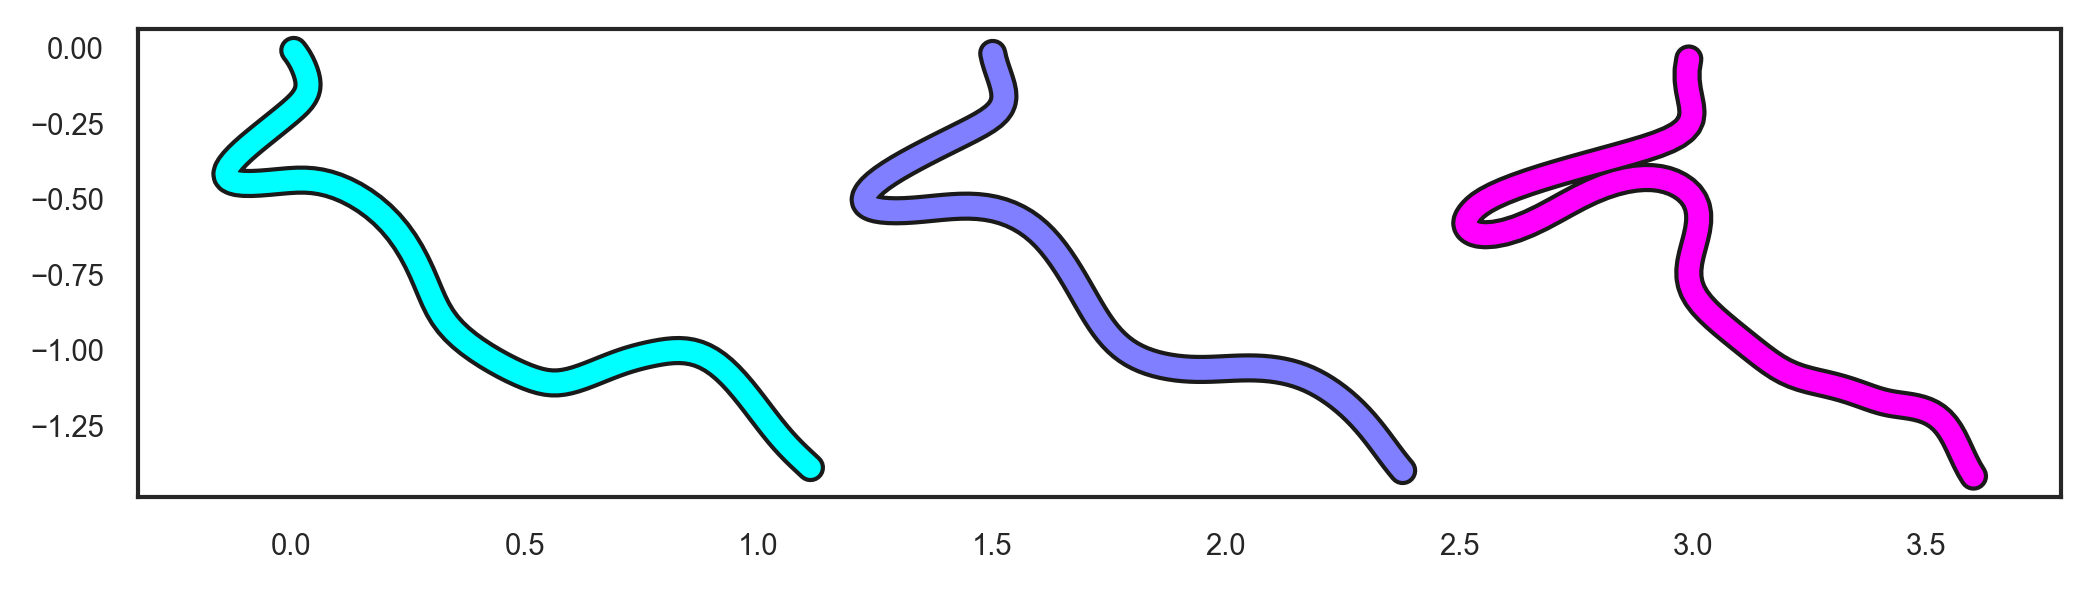

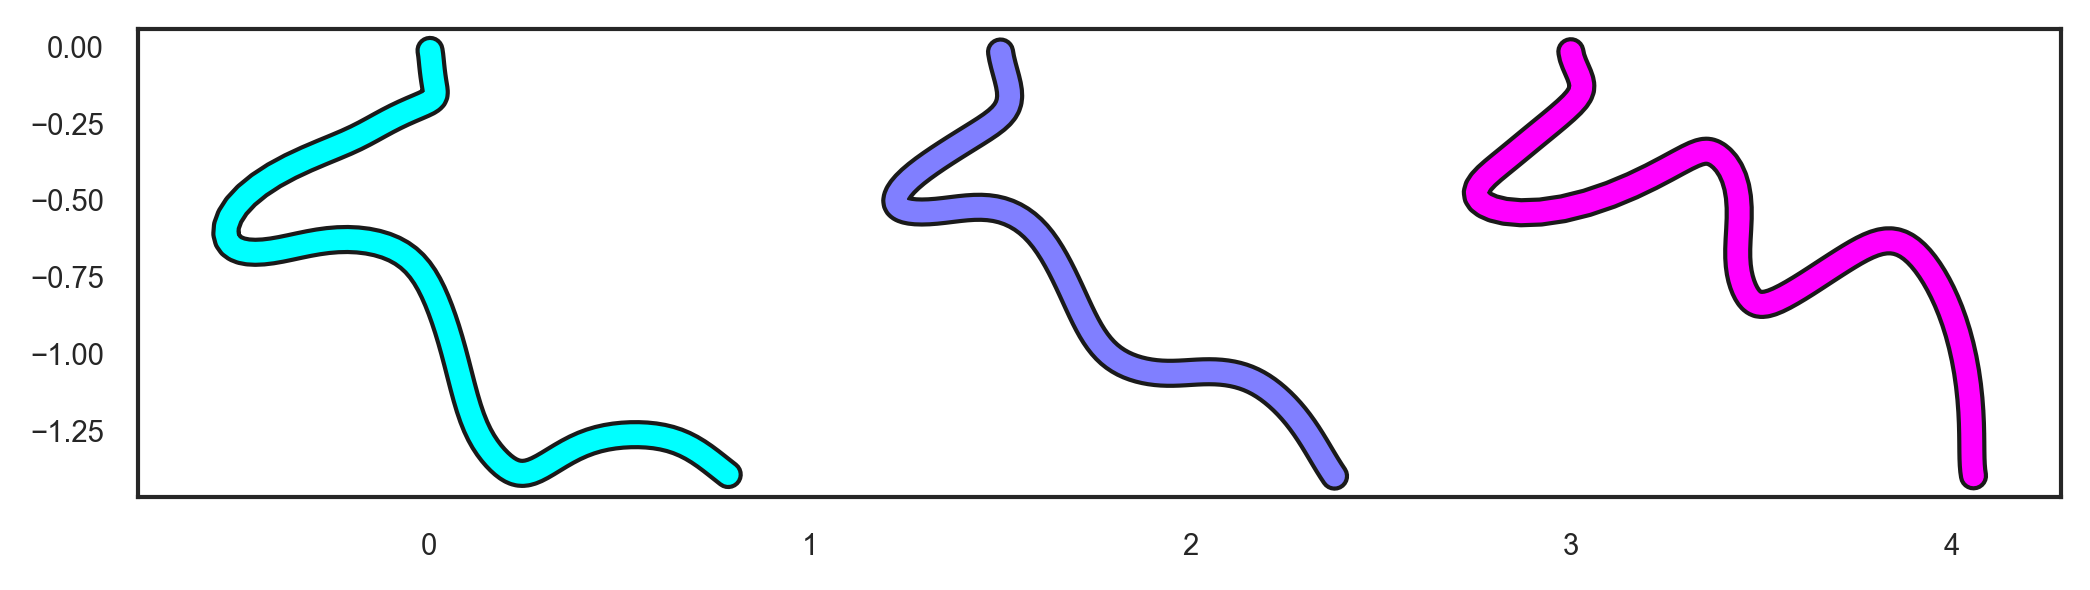

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

base_curve = np.mean(tangent_projected_data, axis=0)
sigma = np.std(tangent_projected_data, axis=0)
times = np.linspace(-3, 3, 15)  # 曲线的数量
synthetic_curves_by_component = []

# 用来记录第一条曲线的 y 方向高度
first_curve_y_range = None

# 计算等距的 x 轴偏移量
x_offsets = np.linspace(0, len(times) * 0.2, len(times))  # 生成等距的 x 轴偏移

for i in range(2):
    fig = plt.figure(figsize=(7, 2), dpi=300)
    ax = fig.add_subplot(111)
    all_points = []
    component_values = []
    
    # Normalize times to range between 0 and 1 for colormap scaling
    norm_times = (times - times.min()) / (times.max() - times.min())
    
    for idx, t in enumerate(times):
        ft = base_curve.copy()
        ft[i] = ft[i] + t * sigma[i]
        
        # Reconstruct the curve
        reconstructed_step_curve = from_tangentPCA_feature_to_curves(tpca, tangent_base, np.array([ft]), 
                                                                      tPCA_N_COMPONENTS, 
                                                                      discrete_curves_space)[0]
        
        # Adjust the z-coordinate to separate the curves (assuming z is the 0th column)
        points = reconstructed_step_curve[:, [2, 1, 0]] * 2.5  # Adjust the order if necessary
        
        # 获取当前曲线的 y 坐标的最大值和最小值
        y_max = np.max(points[:, 1])
        y_min = np.min(points[:, 1])
        y_range = y_max - y_min

        if first_curve_y_range is None:
            # 如果是第一条曲线，记录它的 y 方向高度
            first_curve_y_range = y_range
        else:
            # 对其他曲线进行均匀缩放
            scale_factor = first_curve_y_range / y_range
            points *= scale_factor  # 对 x, y, z 坐标进行均匀缩放

        # 根据计算的等距偏移量移动曲线的第一个点在 x 轴方向上的位置
        points[:, 0] += x_offsets[idx]  # 使用等距偏移量
        all_points.append(points)
        component_values.append(t)

        # Get color from 'coolwarm' colormap
        color = cm.cool(norm_times[idx])  # norm_times[idx] will range between 0 and 1

        # Plot each curve with the assigned color
        if idx in [0, 7, 14]:

            plt.plot(points[:, 0], points[:, 1], color="k", linewidth=7)
            plt.plot(points[:, 0], points[:, 1], color=color, linewidth=5)


    plt.tight_layout()


In [23]:
# import numpy as np
# import matplotlib.colors as mcolors
# ticklabels_c = [f'C{i}' for i in range(5)]
# ticklabels_t = [f'T{i}' for i in range(5)]
# # 设置colormap
# cmap = plt.get_cmap("coolwarm")
# norm = mcolors.Normalize(vmin=0, vmax=len(synthetic_curves_by_component))

# sns.set_context('notebook', font_scale=0.8)
# synthetic_gc_dir = mkdir("./", 'synthetic_gc')
# fig1, axes1 = plt.subplots(nrows=4, ncols=4, figsize=(9, 8), dpi=100)
# fig2, axes2 = plt.subplots(nrows=4, ncols=4, figsize=(9, 8), dpi=100)
# fig3, axes3 = plt.subplots(nrows=4, ncols=4, figsize=(9, 8), dpi=100)
# fig4, axes4 = plt.subplots(nrows=4, ncols=4, figsize=(9, 8), dpi=100)
# fig5, axes5 = plt.subplots(nrows=4, ncols=4, figsize=(9, 8), dpi=100)
# fig6, axes6 = plt.subplots(nrows=4, ncols=4, figsize=(9, 8), dpi=100)
# fig7, axes7 = plt.subplots(nrows=4, ncols=4, figsize=(9, 8), dpi=100)
# fig8, axes8 = plt.subplots(nrows=4, ncols=4, figsize=(9, 8), dpi=100)
# for i in range(len(synthetic_curves_by_component)):
#     ax1 = axes1[i // 4, i % 4]
#     ax2 = axes2[i // 4, i % 4]
#     ax3 = axes3[i // 4, i % 4]
#     ax4 = axes4[i // 4, i % 4]
#     synthetic_curvature = []
#     synthetic_torsion = []
#     synthetic_curvature_peaks = []
#     synthetic_torsion_peaks = []
#     overall_synthetic_curvature_shift = []
#     overall_synthetic_torsion_shift = []
#     overall_synthetic_curvature_intensity = []
#     overall_synthetic_torsion_intensity = []

#     for j in range(len(synthetic_curves_by_component[i])):
#         c,t = compute_curvature_and_torsion(synthetic_curves_by_component[i][j]*90)
#         fft_c = remove_high_freq_components(c, 0.06)
#         fft_t = remove_high_freq_components(t, 0.06)
#         peak_c = find_peaks(fft_c, height=0, distance=15)[0][:5]
#         peak_t = find_peaks(fft_t, height=0, distance=10)[0][:5]
#         # synthetic_curvature.append(fft_c)
#         # synthetic_torsion.append(fft_t)
#         synthetic_curvature_peaks.append(peak_c)
#         synthetic_torsion_peaks.append(peak_t)
#         synthetic_curvature.append(np.array(fft_c)[np.array(peak_c)])
#         synthetic_torsion.append(np.array(fft_t)[np.array(peak_t)])
#         # 为当前的 j 选择颜色，保证同一个 j 内颜色相同
#         color = cmap(norm(j))
        
#         # 使用相同的颜色绘制 5 个点
#         # ax1.scatter(peak_c, np.array(fft_c)[np.array(peak_c)], color=color, marker='+')
#         # ax2.scatter(peak_t, np.array(fft_t)[np.array(peak_t)], color=color, marker='+')
#         # ax3.plot(fft_c, color=color)
#         ax1.scatter(range(len(peak_c)), (peak_c-curvature_peak_index[:5])/120, color=color, marker='o')
#         ax2.scatter(range(len(peak_t)), (peak_t-torsion_peak_index[:len(peak_t)])/120, color=color, marker='o')
#         ax3.scatter(range(len(peak_c)), np.array(fft_c)[np.array(peak_c)]/curvature_intensity_mean[:len(peak_c)], color=color, marker='o')
#         ax4.scatter(range(len(peak_t)), np.array(fft_t)[np.array(peak_t)]/torsion_intensity_mean[:len(peak_t)], color=color, marker='o')
#         ax1.set_ylim(-0.15,0.15)
#         ax2.set_ylim(-0.2,0.6)
#         ax3.set_ylim(0,1.6)
#         ax4.set_ylim(0,1.6)
#         ax1.set_xticks(range(5))
#         ax1.set_xticklabels(ticklabels_c,rotation=45)
#         ax2.set_xticks(range(5))
#         ax2.set_xticklabels(ticklabels_t,rotation=45)
#         ax3.set_xticks(range(5))
#         ax3.set_xticklabels(ticklabels_c,rotation=45)
#         ax4.set_xticks(range(5))
#         ax4.set_xticklabels(ticklabels_t,rotation=45)
#         overall_synthetic_curvature_shift.append(np.mean((peak_c-curvature_peak_index[:5])/120))
#         overall_synthetic_torsion_shift.append(np.mean((peak_t-torsion_peak_index[:5])/120))
#         overall_synthetic_curvature_intensity.append(np.mean(np.array(fft_c)[np.array(peak_c)]/curvature_intensity_mean[:len(peak_c)]))
#         overall_synthetic_torsion_intensity.append(np.mean(np.array(fft_t)[np.array(peak_t)]/torsion_intensity_mean[:len(peak_t)]))
#     ax1.text(0.03, -0.13, str(i+1), fontsize=30, color='gray', alpha=0.5, ha='left', va='bottom', weight='bold')
#     ax2.text(0.03, -0.15, str(i+1), fontsize=30, color='gray', alpha=0.5, ha='left', va='bottom', weight='bold')
#     ax3.text(0.03, 0.04, str(i+1), fontsize=30, color='gray', alpha=0.5, ha='left', va='bottom', weight='bold')
#     ax4.text(0.03, 0.04, str(i+1), fontsize=30, color='gray', alpha=0.5, ha='left', va='bottom', weight='bold')



#     # synthetic_curvature_peaks_df = pd.DataFrame(synthetic_curvature_peaks)
#     # synthetic_curvature_peaks_shift_df = synthetic_curvature_peaks_df / len(curvatures[0])
#     # synthetic_curvature_df = pd.DataFrame(synthetic_curvature)
#     # synthetic_curvature_peaks_shift_df.to_csv(synthetic_gc_dir+f'synthetic_curvature_peaks_{i+1}.csv')
#     # synthetic_curvature_df.to_csv(synthetic_gc_dir+f'synthetic_curvature_{i+1}.csv')

#     # synthetic_torsion_peaks_df = pd.DataFrame(synthetic_torsion_peaks)
#     # synthetic_torsion_peaks_shift_df = synthetic_torsion_peaks_df / len(curvatures[0])
#     # synthetic_torsion_df = pd.DataFrame(synthetic_torsion)
#     # synthetic_torsion_peaks_shift_df.to_csv(synthetic_gc_dir+f'synthetic_torsion_peaks_{i+1}.csv')
#     # synthetic_torsion_df.to_csv(synthetic_gc_dir+f'synthetic_torsion_{i+1}.csv')
#     fig1.tight_layout()
#     fig2.tight_layout()
#     fig3.tight_layout()
#     fig4.tight_layout()


In [21]:
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors

# sns.set_context('notebook', font_scale=1.15)
# mean_tangent_projected_data = np.mean(tangent_projected_data, axis=0)
# std_tangent_projected_data = np.std(tangent_projected_data, axis=0)
# print (mean_tangent_projected_data.shape)

# # 生成一个包含所有可能偏移的数据集
# atlas_projected_data = []


# time_length= 15
# sigma=np.linspace(-1.5,1.5,time_length)
# for i in range(tPCA_N_COMPONENTS):
#     for j in sigma:
#         a_project_data = mean_tangent_projected_data.copy()
#         a_project_data[i] += std_tangent_projected_data[i]*j
#         atlas_projected_data.append(a_project_data)
# atlas_projected_data = np.array(atlas_projected_data)
# print (atlas_projected_data.shape)
# atlas_projected_data= atlas_projected_data.reshape(tPCA_N_COMPONENTS,time_length,-1)
# print (atlas_projected_data.shape)

# num_curves = len(sigma)  # 获取曲线的数量

# # 创建颜色映射和标准化对象
# cmap = plt.get_cmap('crest')
# norm = mcolors.Normalize(vmin=0, vmax=num_curves-1)

# # 使用 ScalarMappable 来映射颜色
# scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

# def align_one_to_all(obj_curvature, fft_c):
#     obj_c_temp = fs.fdawarp(np.vstack([obj_curvature.fmean, fft_c]).T, time)
#     # 使用 srsf_align 对新数据进行对齐，假设 mean_curve 是第一个数据
#     obj_c_temp.srsf_align(MaxItr=100, parallel=True)
#     # 获取对齐后的数据
#     print ("obj_c_temp.fn:", obj_c_temp.fn.shape)
#     aligned_fft_c = obj_c_temp.fn[:, 1]  # 获取第二行，即新对齐的数据
#     new_data_warping = obj_c_temp.gam[:,1]
#     return aligned_fft_c, new_data_warping

# print ("atlas_projected_data.shape:",atlas_projected_data.shape)


# synthetic_fpca_loadings = []
# for atlas_projected_d in atlas_projected_data:
#     print (atlas_projected_d.shape)
#     # fig_s = plt.figure(figsize=(9,8), dpi=50)
#     # ax_s = fig_s.add_subplot(111)
#     # sns.scatterplot(x=tangent_projected_data[:, 0], y=tangent_projected_data[:, 1], edgecolor='black',c="white",ax=ax_s)
#     fig = plt.figure(figsize=(18,9), dpi=100)
#     gs = gridspec.GridSpec(2, 3, height_ratios=[5,5], width_ratios=[2, 8, 3])
#     # The first subplot (standard deviation line plot).
#     ax1 = fig.add_subplot(gs[:, 0])  # First row, first column
#     ax2 = fig.add_subplot(gs[0, 1])  # Second row, first column
#     ax3 = fig.add_subplot(gs[1, 1])  # First row, second column
#     ax4 = fig.add_subplot(gs[0, 2])  # Second row, second column
#     ax5 = fig.add_subplot(gs[1, 2])  # First row, second column
#     # sns.scatterplot(x=atlas_projected_d[:, 0], y=atlas_projected_d[:, 1], edgecolor='black',c=range(len(atlas_projected_d)),cmap=cmap,ax=ax_s)
#     atlas_reconstructed_synthetic_curves = from_tangentPCA_feature_to_curves(tpca, tangent_base, atlas_projected_d, 
#                                                                                 tPCA_N_COMPONENTS, 
#                                                                                 discrete_curves_space)
#     print (atlas_reconstructed_synthetic_curves.shape)
        
#     # 假设 reconstructed_synthetic_curves 是已定义的曲线数组
#     for i in range(len(atlas_reconstructed_synthetic_curves)):
#         # 获取当前索引的颜色
#         # print (atlas_reconstructed_synthetic_curves[i].shape)
#         color = scalar_mappable.to_rgba(i)
#         # 绘制曲线
#         # sns.lineplot(x=atlas_reconstructed_synthetic_curves[i][:, 0], y=atlas_reconstructed_synthetic_curves[i][:, 1], linewidth=1, color=color, ax=ax1)
        
#         ax1.plot(atlas_reconstructed_synthetic_curves[i][:,0],atlas_reconstructed_synthetic_curves[i][:,1], linewidth=2,color=color)
#         c,t = compute_curvature_and_torsion(atlas_reconstructed_synthetic_curves[i]*180)
#         fft_c= remove_high_freq_components(c,0.06)
#         fft_t = remove_high_freq_components(t,0.06)
#         # print (obj_curvature.fmean.shape, fft_c.shape, time.shape,np.stack([obj_curvature.fmean, fft_c]).T.shape)
        
#         # 如果需要，也可以获取时间扭曲函数
#         aligned_fft_c, new_data_warping_c = align_one_to_all(obj_curvature, fft_c)
#         aligned_fft_t, new_data_warping_t = align_one_to_all(obj_torsion, fft_t)

#         # new_data_srsf_c = np.append(fs.f_to_srsf(aligned_fft_c, obj_curvature.time),0)
#         # print ("new_data_srsf_c:",new_data_srsf_c.shape, vpca_curvature.q_pca.shape, vpca_curvature.mqn.shape)
#         # loadings_c = np.dot(vpca_curvature.q_pca, new_data_srsf_c - vpca_curvature.mqn)
#         # new_data_srsf_t = np.append(fs.f_to_srsf(aligned_fft_t, obj_torsion.time),0)
#         # loadings_t = np.dot(vpca_torsion.q_pca, new_data_srsf_t - vpca_torsion.mqn)
#         # synthetic_fpca_loadings.append((loadings_c,loadings_t))


#         ax2.plot(aligned_fft_c ,color=color)
#         # ax2.plot(obj_curvature.fmean,color='k')
#         ax3.plot(aligned_fft_t ,color=color)
#         ax4.plot(new_data_warping_c ,color=color)
#         ax5.plot(new_data_warping_t ,color=color)
#         ax4.plot([0,119],[0,1],c='k', linestyle='--')
#         ax5.plot([0,119],[0,1],c='k', linestyle='--')
#     for ax in [ax2,ax3,ax4,ax5]:
#         ax.autoscale(enable=True, axis='x', tight=True)
#         # ax.grid(linestyle='--', linewidth=0.5, alpha=0.7)
#         ax.set_xticks(np.linspace(0, len(autocovariance_values), num=5))  # 在0到199之间平均放置5个刻度
#         # 设置横轴的刻度标签，将其转换为百分比
#         ax.set_xticklabels(['{}'.format(x) for x in np.linspace(0, 1, num=5)])
#     plt.tight_layout()



In [22]:


# print (np.vstack([kappa_dot, tau_dot]).T.shape)
# print (c_peak_movement.shape)

# 假设tangent_projected_data是你的数据数组
# 提取前三个维度作为点坐标
points = tangent_projected_data[:, :3]
 

kappa_tau_dots = np.vstack([kappa_moves,tau_moves,kappa_values,tau_values]).T
# attributes = np.hstack([c_peak_movement,t_peak_movement,c_peak_values,t_peak_values,kappa_tau_dots])
# attribute_names = ['c_peak_movement_0','c_peak_movement_1','c_peak_movement_2','c_peak_movement_3','c_peak_movement_4',
#                     't_peak_movement_0','t_peak_movement_1','t_peak_movement_2','t_peak_movement_3','t_peak_movement_4',
#                     'c_peak_values_0','c_peak_values_1','c_peak_values_2','c_peak_values_3','c_peak_values_4',
#                     't_peak_values_0','t_peak_values_1','t_peak_values_2','t_peak_values_3','t_peak_values_4',
#                     "kappa_moves","tau_moves","kappa_values","tau_values"]

attributes = np.vstack([kappa_moves,tau_moves,kappa_values,tau_values]).T
attribute_names = ["kappa_moves","tau_moves","kappa_values","tau_values"]



def generate_vtk_with_curves(filename, points, curve_bs, attribute_names, attributes):
    """
    生成包含点和对应曲线的VTK文件，确保每个曲线的中心落在对应的点上
    :param filename: 输出的VTK文件名
    :param points: 点的坐标列表
    :param curve_bs: 曲线的坐标列表，每个点对应一条曲线
    :param attribute_names: 属性名称列表
    :param attributes: 属性值列表
    """
    with open(filename, 'w') as file:
        file.write("# vtk DataFile Version 3.0\n")
        file.write("tangent_project_data\n")
        file.write("ASCII\n")
        file.write("DATASET POLYDATA\n")

        total_points = len(points) * len(curve_bs[0])
        file.write(f"POINTS {total_points} float\n")

        for i, point in enumerate(points):
            curve = curve_bs[i]
            curve_center = np.mean(curve, axis=0)
            adjusted_curve = curve - curve_center + point
            for c in adjusted_curve:
                file.write(f"{c[0]} {c[1]} {c[2]}\n")

        total_lines = len(points)
        line_size = len(curve_bs[0])
        file.write(f"LINES {total_lines} {total_lines * (1 + line_size)}\n")
        
        for i in range(len(points)):
            file.write(f"{line_size}")
            for j in range(line_size):
                file.write(f" {i * line_size + j}")
            file.write("\n")

        file.write(f"CELL_DATA {total_lines}\n")
        for i, name in enumerate(attribute_names):
            file.write(f"SCALARS {name} float 1\n")
            file.write("LOOKUP_TABLE default\n")
            for attribute in attributes:
                file.write(f"{attribute[i]}\n")


# generate_vtk_with_curves('tangent_project_data_v2.vtk', points, curve_bs, attribute_names, attributes)
# generate_vtk_with_curves('pca_data_v2.vtk', points, curve_bs, attribute_names, attributes)
# generate_vtk_with_curves('pca_project_v2_2.vtk', results[:,:3], curve_bs*20, attribute_names, attributes)

In [23]:
def translate_curve(curve, target_point):
    """
    计算曲线的3D重心并将其平移到新的2D目标点。
    
    参数:
    curve : ndarray
        曲线的点坐标，形状为 (n, 3)。
    target_point : ndarray
        目标点的2D坐标，形状为 (2,)。
    
    返回:
    translated_x : ndarray
        平移后曲线的x坐标。
    translated_y : ndarray
        平移后曲线的y坐标。
    """
    # 计算3D重心
    centroid = np.mean(curve, axis=0)
    
    # 计算x和y方向的位移
    dx = target_point[0] - centroid[0]
    dy = target_point[1] - centroid[1]
    
    # 平移曲线
    translated_x = curve[:, 0] + dx
    translated_y = curve[:, 1] + dy
    
    return translated_x, translated_y

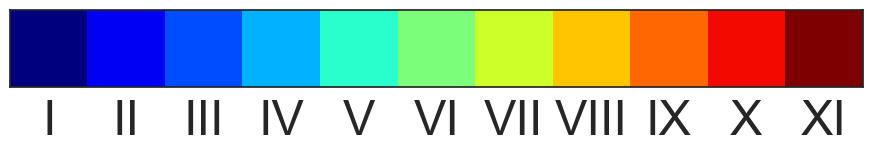

In [24]:
import numpy as np
from matplotlib import pyplot as plt

# 原始的字典
type_index_dist = {0: "I", 63: "II", 22: "III", 39: "IV", 30: "V", 17: "VI", 29: "VII", 10: "VIII", 45: "IX", 74: "X", 61: "XI"}
# type_index_dist = {0: "I", 63: "II", 22: "III", 39: "IV", 30: "V", 17: "VI", 29: "VII", 10: "VIII", 45: "IX", 9: "X", 61: "XI"}

# 获取所有的key
key_list = list(type_index_dist.keys())

# 颜色数量等于字典中项目的数量
num_colors = len(key_list)

# 获取jet colormap，并将其分成离散的颜色
jet = plt.get_cmap('jet', num_colors)

# 生成颜色对应表
color_mapping = {key: jet(i) for i, key in enumerate(type_index_dist)}

# 输出 color_mapping
# 创建一个矩阵，方便使用 imshow 展示颜色
color_array = np.array([list(color_mapping.values())])

# 绘制颜色条
plt.figure(figsize=(11, 1))
plt.imshow(color_array, aspect='auto')
plt.xticks(ticks=np.arange(num_colors), labels=type_index_dist.values(), rotation=0, fontsize=35)
plt.yticks([])  # 不显示y轴的标签
# plt.title('Discrete Jet Colormap')
# plt.colorbar()  # 可选，显示颜色条
plt.show()

In [88]:
for i in range(len(key_list)):
    # print (type_index_dist[key_list[i]], "MoD 1:", round(tangent_projected_data[key_list[i], 0], 3), ",",round(tangent_projected_data[key_list[i], 1], 3))
    print (round(kappa_moves[key_list[i]], 3), round(tau_moves[key_list[i]], 3), round(kappa_values[key_list[i]], 3), round(tau_values[key_list[i]], 3))


-0.034 -0.038 0.868 0.884
-0.086 -0.073 0.799 1.281
-0.017 -0.018 1.041 0.086
-0.039 -0.03 1.006 1.801
0.002 0.016 1.181 1.157
0.003 -0.003 0.888 1.481
-0.007 0.003 1.124 0.942
0.015 0.011 0.965 -0.085
0.025 0.022 0.848 1.918
0.069 0.064 1.052 0.611
0.001 0.002 1.279 1.141


kappa_moves
(79,)
Bin edges for y_continuous: [-0.08629721 -0.03892445 -0.01645821  0.0031391   0.02951508  0.11189293]
Bin 0: -0.0863 to -0.0389
Bin 1: -0.0389 to -0.0165
Bin 2: -0.0165 to 0.0031
Bin 3: 0.0031 to 0.0295
Bin 4: 0.0295 to 0.1119
Best Parameters: {'C': 600, 'gamma': 0.1, 'kernel': 'rbf'}
Cross-validation Accuracy Scores: [0.1875     0.3125     0.5625     0.5625     0.53333333]
Mean Cross-validation Accuracy: 0.43166666666666664
(27000, 5)
key_list.index(i): 0
key_list.index(i): 7
key_list.index(i): 5
key_list.index(i): 2
key_list.index(i): 6
key_list.index(i): 4
key_list.index(i): 3
key_list.index(i): 8
key_list.index(i): 10
key_list.index(i): 1
key_list.index(i): 9


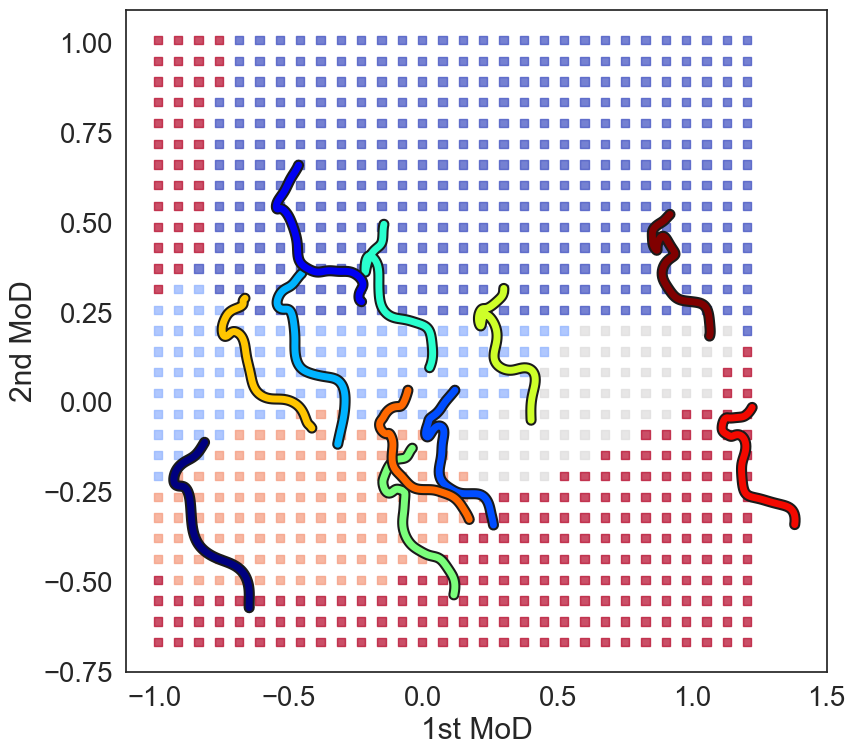

=====
tau_moves
(79,)
Bin edges for y_continuous: [-0.07314024 -0.03397883 -0.00836671  0.00255164  0.02603318  0.10053126]
Bin 0: -0.0731 to -0.0340
Bin 1: -0.0340 to -0.0084
Bin 2: -0.0084 to 0.0026
Bin 3: 0.0026 to 0.0260
Bin 4: 0.0260 to 0.1005
Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Cross-validation Accuracy Scores: [0.25       0.4375     0.4375     0.375      0.53333333]
Mean Cross-validation Accuracy: 0.4066666666666666
(27000, 5)
key_list.index(i): 0
key_list.index(i): 7
key_list.index(i): 5
key_list.index(i): 2
key_list.index(i): 6
key_list.index(i): 4
key_list.index(i): 3
key_list.index(i): 8
key_list.index(i): 10
key_list.index(i): 1
key_list.index(i): 9


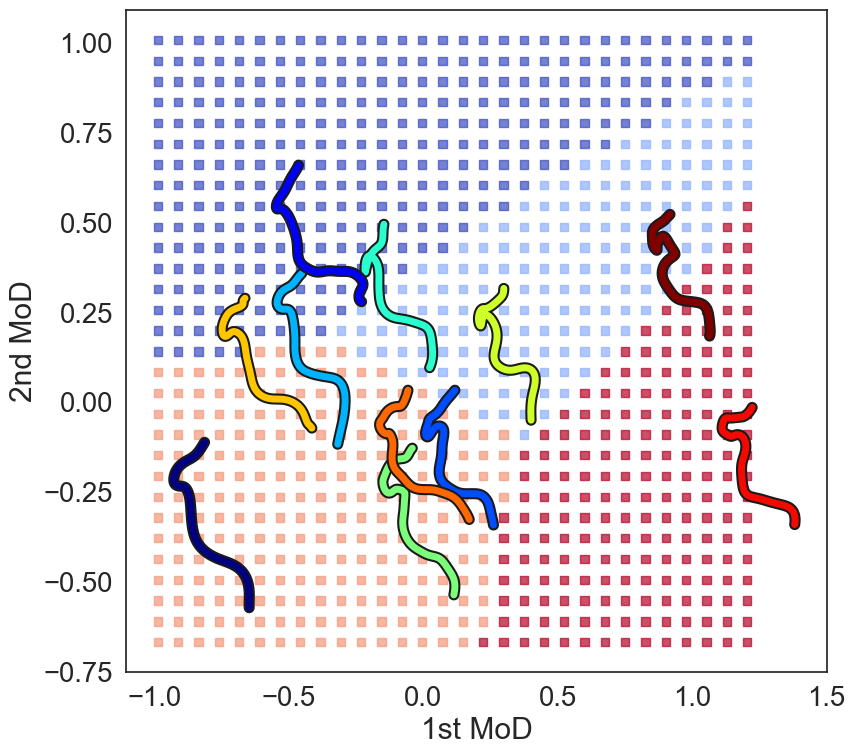

=====
kappa_values
(79,)
Bin edges for y_continuous: [0.68681977 0.85159046 0.95219357 1.04248162 1.17037453 1.4573306 ]
Bin 0: 0.6868 to 0.8516
Bin 1: 0.8516 to 0.9522
Bin 2: 0.9522 to 1.0425
Bin 3: 1.0425 to 1.1704
Bin 4: 1.1704 to 1.4573
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Cross-validation Accuracy Scores: [0.375      0.3125     0.375      0.4375     0.46666667]
Mean Cross-validation Accuracy: 0.39333333333333337
(27000, 5)
key_list.index(i): 0
key_list.index(i): 7
key_list.index(i): 5
key_list.index(i): 2
key_list.index(i): 6
key_list.index(i): 4
key_list.index(i): 3
key_list.index(i): 8
key_list.index(i): 10
key_list.index(i): 1
key_list.index(i): 9


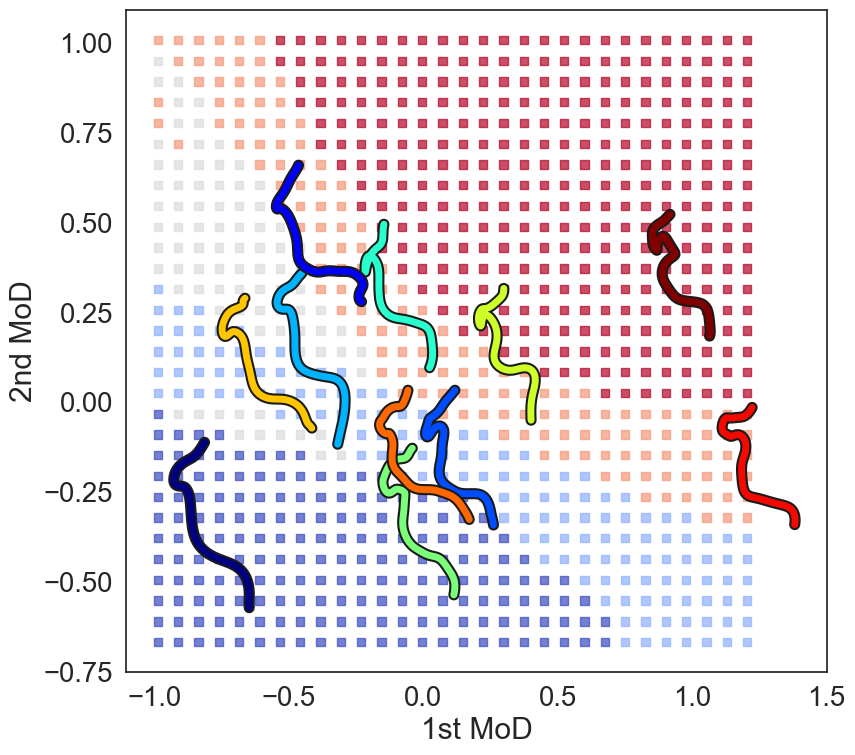

=====
tau_values
(79,)
Bin edges for y_continuous: [-0.1906628   0.37050983  0.82197352  1.12801584  1.55384901  2.13213519]
Bin 0: -0.1907 to 0.3705
Bin 1: 0.3705 to 0.8220
Bin 2: 0.8220 to 1.1280
Bin 3: 1.1280 to 1.5538
Bin 4: 1.5538 to 2.1321
Best Parameters: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
Cross-validation Accuracy Scores: [0.125      0.375      0.3125     0.375      0.26666667]
Mean Cross-validation Accuracy: 0.29083333333333333
(27000, 5)
key_list.index(i): 0
key_list.index(i): 7
key_list.index(i): 5
key_list.index(i): 2
key_list.index(i): 6
key_list.index(i): 4
key_list.index(i): 3
key_list.index(i): 8
key_list.index(i): 10
key_list.index(i): 1
key_list.index(i): 9


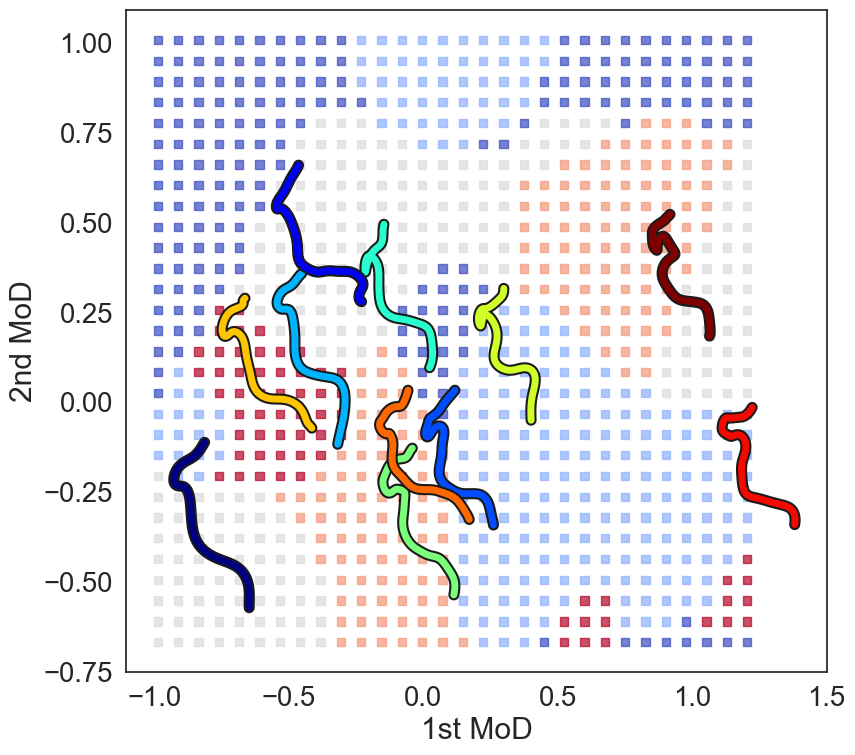

=====


In [25]:

svm_dir = mkdir("./", "svm")


# 将每组相邻类之间的决策边界写入VTK文件
def write_vtk(filename, decision_values, n_classes, x_range, y_range, z_range):
    polydata = vtk.vtkPolyData()
    points = vtk.vtkPoints()
    polys = vtk.vtkCellArray()
    cell_labels = vtk.vtkIntArray()
    cell_labels.SetName("BoundaryLabel")
    
    point_index_offset = 0

    for i in range(n_classes):
        for j in range(i + 1, n_classes):
            decision_boundary = decision_values[:, i] - decision_values[:, j]
            decision_boundary = decision_boundary.reshape((grid_size, grid_size, grid_size))
            
            # 找到决策边界，确保level在数据范围内
            min_value, max_value = decision_boundary.min(), decision_boundary.max()
            level = 0.5 * (min_value + max_value)
            verts, faces, normals, values = measure.marching_cubes(decision_boundary, level=level)
            
            # 将 verts 转换到原始坐标范围并添加到 points 和 polys 中
            for vert in verts:
                x = x_range[0] + vert[0] * (x_range[-1] - x_range[0]) / (len(x_range) - 1)
                y = y_range[0] + vert[1] * (y_range[-1] - y_range[0]) / (len(y_range) - 1)
                z = z_range[0] + vert[2] * (z_range[-1] - z_range[0]) / (len(z_range) - 1)
                points.InsertNextPoint(x, y, z)

            for face in faces:
                polys.InsertNextCell(3)
                polys.InsertCellPoint(face[0] + point_index_offset)
                polys.InsertCellPoint(face[1] + point_index_offset)
                polys.InsertCellPoint(face[2] + point_index_offset)
                cell_labels.InsertNextValue(i * n_classes + j)

            point_index_offset += len(verts)

    polydata.SetPoints(points)
    polydata.SetPolys(polys)
    polydata.GetCellData().AddArray(cell_labels)

    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(filename)
    writer.SetInputData(polydata)
    writer.Write()

# 将grid数据和预测标签写入.particles文件
def write_particles_with_labels(filename, grid, labels):
    with open(filename, 'w') as f:
        for point, label in zip(grid, labels):
            f.write(f"{point[0]} {point[1]} {point[2]} {label}\n")

def rotate_curve_around_y(curve, theta):
    """
    对给定的3D曲线围绕Y轴进行旋转。
    
    参数:
    curve: (n, 3) 形状的 numpy 数组，表示曲线的 n 个点，每个点有 x, y, z 坐标。
    theta: 旋转角度，单位为弧度。
    
    返回:
    rotated_curve: 旋转后的曲线，形状为 (n, 3)。
    """
    # 旋转矩阵 (绕Y轴旋转)
    rotation_matrix_y = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    
    # 对曲线的每个点应用旋转矩阵
    rotated_curve = np.dot(curve, rotation_matrix_y.T)  # 使用转置使矩阵乘法生效
    
    return rotated_curve

def rotate_curve_around_z(curve, theta):
    """
    对给定的3D曲线围绕Z轴进行旋转。
    
    参数:
    curve: (n, 3) 形状的 numpy 数组，表示曲线的 n 个点，每个点有 x, y, z 坐标。
    theta: 旋转角度，单位为弧度。
    
    返回:
    rotated_curve: 旋转后的曲线，形状为 (n, 3)。
    """
    # 旋转矩阵 (绕Z轴旋转)
    rotation_matrix_z = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    
    # 对曲线的每个点应用旋转矩阵
    rotated_curve = np.dot(curve, rotation_matrix_z.T)  # 使用转置使矩阵乘法生效
    
    return rotated_curve

grid_size =  30  # 网格点的数量

# 对连续的属性值进行分桶操作，将其转换为离散标签
# attribute_index = 1  # 选择要用来分类的属性索引
for attribute_index in range(len(attribute_names)):
    print (attribute_names[attribute_index])
    y_continuous = attributes[:, attribute_index]

    # 使用KBinsDiscretizer进行分桶
    n_bins = 5 # 这里我们将连续属性值分成四个桶
    kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    y_binned = kbins.fit_transform(y_continuous.reshape(-1, 1)).astype(int).ravel()
    print (y_binned.shape)
    # 获取并打印每个桶的边界
    bin_edges = kbins.bin_edges_[0]  # bin_edges_ 是一个列表的列表，每个子列表对应一个特征的边界
    print("Bin edges for y_continuous:", bin_edges)

    # 打印每个桶对应的连续值范围
    for i in range(len(bin_edges) - 1):
        print(f"Bin {i}: {bin_edges[i]:.4f} to {bin_edges[i+1]:.4f}")


    # 使用tangent_projected_data作为X
    X = tangent_projected_data[:, :3]

    # # 训练SVM模型
    # svm = SVC(kernel='rbf', C=1, gamma='auto', decision_function_shape='ovr')
    # svm.fit(X, y_binned)

    param_grid = {
        'C': [0.1, 1, 10, 100, 600],  # 扩展到更高和更低的C值
        'gamma': [0.001, 0.01, 0.1, 1, 10],  # 同样适用对数尺度扩展gamma
        'kernel': ['rbf']
    }



    # 创建 SVM 模型
    svm = SVC(decision_function_shape='ovr')

    # 创建 GridSearchCV 实例
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=0)

    # 进行参数调优
    grid_search.fit(X, y_binned)

    # 输出最优参数
    print("Best Parameters:", grid_search.best_params_)

    # 使用最优参数训练最终模型
    best_svm = grid_search.best_estimator_

    # 使用交叉验证评估模型性能
    cv_scores = cross_val_score(best_svm, X, y_binned, cv=5, scoring='accuracy')
    print("Cross-validation Accuracy Scores:", cv_scores)
    print("Mean Cross-validation Accuracy:", np.mean(cv_scores))

    # 创建网格点以绘制决策边界
    x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), grid_size)
    y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), grid_size)
    z_range = np.linspace(X[:, 2].min(), X[:, 2].max(), grid_size)
    xx, yy, zz = np.meshgrid(x_range, y_range, z_range)
    grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

    # 预测每个网格点的标签
    decision_values = best_svm.decision_function(grid)
    grid_predictions = best_svm.predict(grid)
    print (decision_values.shape)


    vis_decision_value = decision_values.reshape((grid_size, grid_size, grid_size, -1))
    # print (vis_decision_value.shape)
    category_indices = np.argmax(vis_decision_value, axis=-1)

    z_index = z_range[z_range.shape[0] // 2]  # 选择中间的 z 值
    # z_index = z_range[z_range.shape[0]*3 // 4]
    selected_points = grid[grid[:, 2] == z_index]
    # 获取对应的类别索引
    selected_categories = category_indices.reshape(-1)[grid[:, 2] == z_index]
    # print (selected_points.shape)

    sns.set_context('notebook', font_scale=1.8)
    # 创建一个 3D 散点图
    fig = plt.figure(figsize=(9, 8), dpi=100)
    ax = fig.add_subplot(111)


    scatter = ax.scatter(selected_points[:, 0], selected_points[:, 1],c=selected_categories,  marker='s', cmap='coolwarm', alpha=0.7)

    # 添加颜色条
    # fig.colorbar(scatter, ax=ax, label='Category')

    for i in range(len(curve_cs)):
        if i in list(type_index_dist.keys()):
            # plt.plot(curve_cs[i][:,0],curve_cs[i][:,1],c='k')
            print ("key_list.index(i):", key_list.index(i))
            temp_curve = rotate_curve_around_z(rotate_curve_around_y(curve_cs[i]/1.3, np.pi / 4), -np.pi / 10)
            translated_x, translated_y = translate_curve(temp_curve, tangent_projected_data[i, :2])
            plt.plot(translated_x, translated_y,  linewidth=8, c="k", alpha=1)
            plt.plot(translated_x, translated_y,  linewidth=5, c=color_mapping[i], alpha=1)
    ax.set_xlabel('1st MoD')
    ax.set_ylabel('2nd MoD')
    plt.tight_layout()
    plt.show()


    # write_vtk(svm_dir + "decision_boundaries_{}.vtk".format(attribute_names[attribute_index]), decision_values, n_bins, x_range, y_range, z_range)
    # write_particles_with_labels(svm_dir + "grid_particles_with_labels_{}.particles".format(attribute_names[attribute_index]), grid, grid_predictions)
    print ("=====")

kappa_moves
(79,)
Bin edges for y_continuous: [-0.08629721 -0.03892445 -0.01645821  0.0031391   0.02951508  0.11189293]
Bin 0: -0.0863 to -0.0389
Bin 1: -0.0389 to -0.0165
Bin 2: -0.0165 to 0.0031
Bin 3: 0.0031 to 0.0295
Bin 4: 0.0295 to 0.1119
Best Parameters: {'C': 600, 'gamma': 0.1, 'kernel': 'rbf'}
Cross-validation Accuracy Scores: [0.1875     0.3125     0.5625     0.5625     0.53333333]
Mean Cross-validation Accuracy: 0.43166666666666664
(27000, 5)


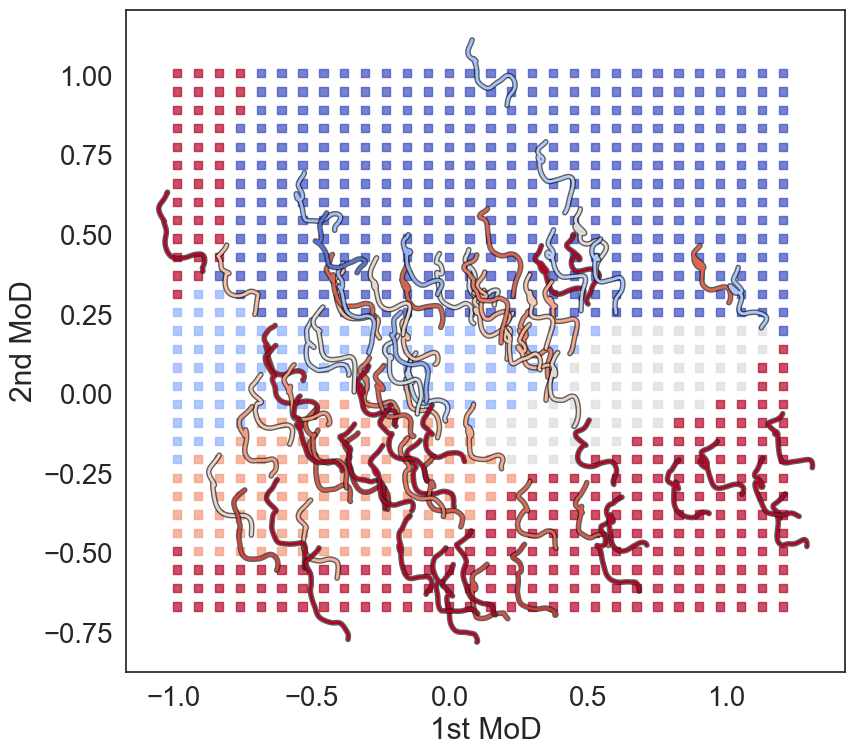

tau_moves
(79,)
Bin edges for y_continuous: [-0.07314024 -0.03397883 -0.00836671  0.00255164  0.02603318  0.10053126]
Bin 0: -0.0731 to -0.0340
Bin 1: -0.0340 to -0.0084
Bin 2: -0.0084 to 0.0026
Bin 3: 0.0026 to 0.0260
Bin 4: 0.0260 to 0.1005
Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Cross-validation Accuracy Scores: [0.25       0.4375     0.4375     0.375      0.53333333]
Mean Cross-validation Accuracy: 0.4066666666666666
(27000, 5)


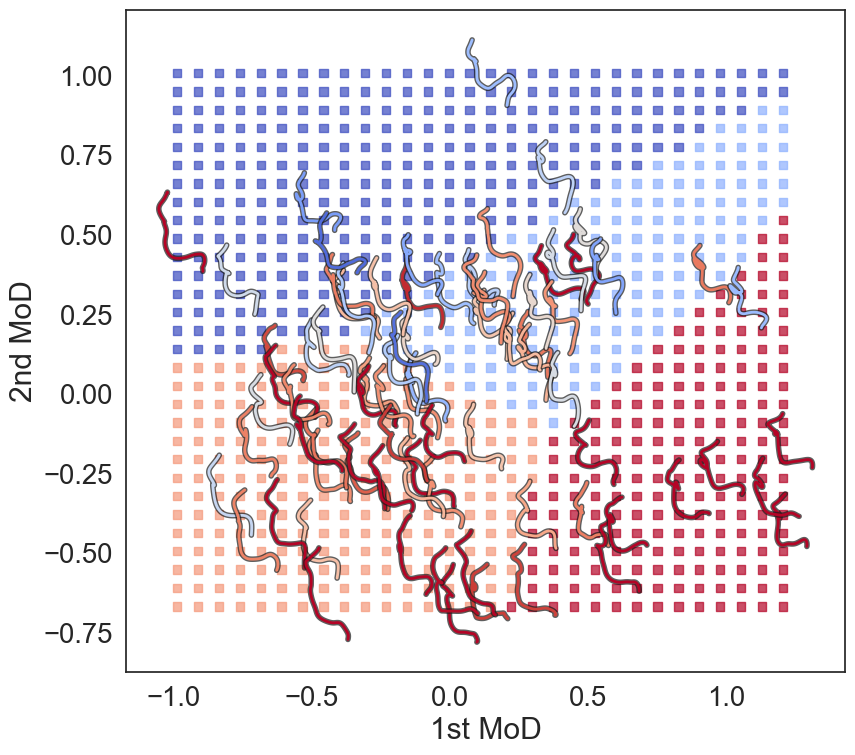

kappa_values
(79,)
Bin edges for y_continuous: [0.68681977 0.85159046 0.95219357 1.04248162 1.17037453 1.4573306 ]
Bin 0: 0.6868 to 0.8516
Bin 1: 0.8516 to 0.9522
Bin 2: 0.9522 to 1.0425
Bin 3: 1.0425 to 1.1704
Bin 4: 1.1704 to 1.4573
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Cross-validation Accuracy Scores: [0.375      0.3125     0.375      0.4375     0.46666667]
Mean Cross-validation Accuracy: 0.39333333333333337
(27000, 5)


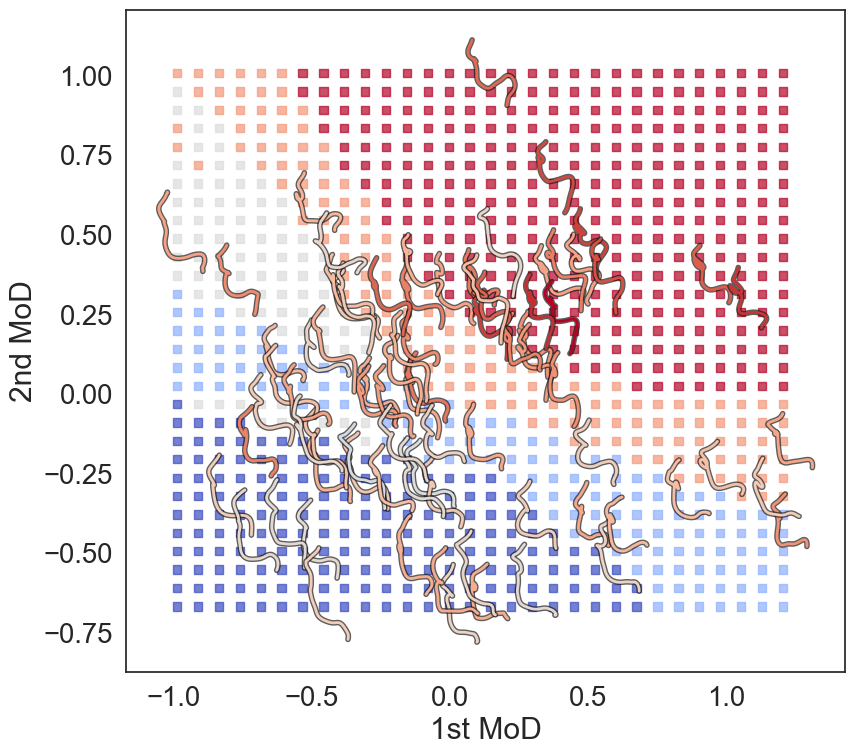

tau_values
(79,)
Bin edges for y_continuous: [-0.1906628   0.37050983  0.82197352  1.12801584  1.55384901  2.13213519]
Bin 0: -0.1907 to 0.3705
Bin 1: 0.3705 to 0.8220
Bin 2: 0.8220 to 1.1280
Bin 3: 1.1280 to 1.5538
Bin 4: 1.5538 to 2.1321
Best Parameters: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
Cross-validation Accuracy Scores: [0.125      0.375      0.3125     0.375      0.26666667]
Mean Cross-validation Accuracy: 0.29083333333333333
(27000, 5)


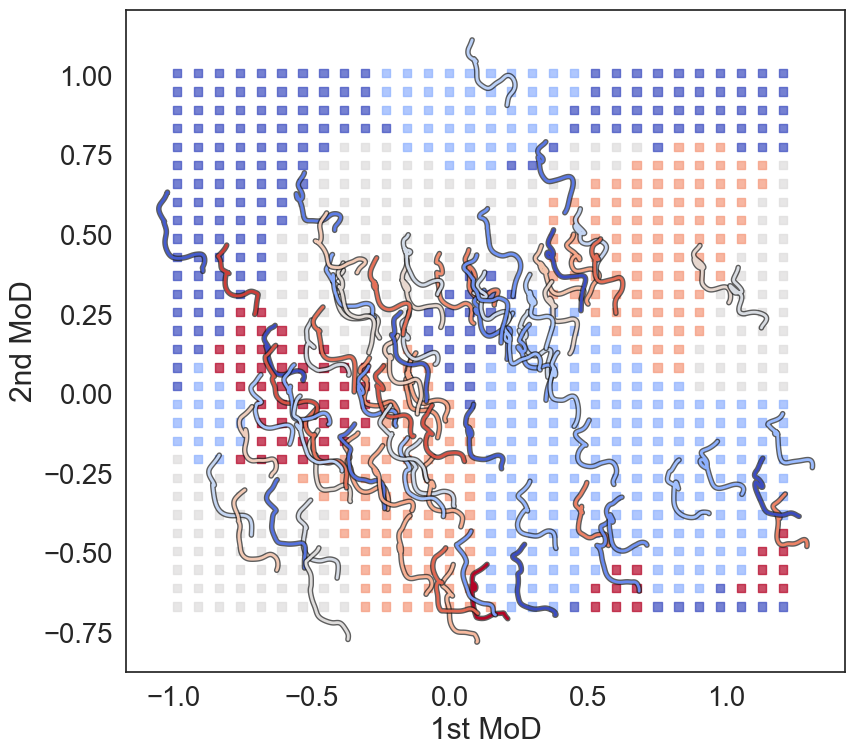

In [46]:
grid_size =  30  # 网格点的数量

# 对连续的属性值进行分桶操作，将其转换为离散标签
# attribute_index = 1  # 选择要用来分类的属性索引
for attribute_index in range(len(attribute_names)):
    print (attribute_names[attribute_index])
    y_continuous = attributes[:, attribute_index]

    # 使用KBinsDiscretizer进行分桶
    n_bins = 5 # 这里我们将连续属性值分成四个桶
    kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    y_binned = kbins.fit_transform(y_continuous.reshape(-1, 1)).astype(int).ravel()
    print (y_binned.shape)
    # 获取并打印每个桶的边界
    bin_edges = kbins.bin_edges_[0]  # bin_edges_ 是一个列表的列表，每个子列表对应一个特征的边界
    print("Bin edges for y_continuous:", bin_edges)

    # 打印每个桶对应的连续值范围
    for i in range(len(bin_edges) - 1):
        print(f"Bin {i}: {bin_edges[i]:.4f} to {bin_edges[i+1]:.4f}")


    # 使用tangent_projected_data作为X
    X = tangent_projected_data[:, :3]

    # # 训练SVM模型
    # svm = SVC(kernel='rbf', C=1, gamma='auto', decision_function_shape='ovr')
    # svm.fit(X, y_binned)

    param_grid = {
        'C': [0.1, 1, 10, 100, 600],  # 扩展到更高和更低的C值
        'gamma': [0.001, 0.01, 0.1, 1, 10],  # 同样适用对数尺度扩展gamma
        'kernel': ['rbf']
    }



    # 创建 SVM 模型
    svm = SVC(decision_function_shape='ovr')

    # 创建 GridSearchCV 实例
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=0)

    # 进行参数调优
    grid_search.fit(X, y_binned)

    # 输出最优参数
    print("Best Parameters:", grid_search.best_params_)

    # 使用最优参数训练最终模型
    best_svm = grid_search.best_estimator_

    # 使用交叉验证评估模型性能
    cv_scores = cross_val_score(best_svm, X, y_binned, cv=5, scoring='accuracy')
    print("Cross-validation Accuracy Scores:", cv_scores)
    print("Mean Cross-validation Accuracy:", np.mean(cv_scores))

    # 创建网格点以绘制决策边界
    x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), grid_size)
    y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), grid_size)
    z_range = np.linspace(X[:, 2].min(), X[:, 2].max(), grid_size)
    xx, yy, zz = np.meshgrid(x_range, y_range, z_range)
    grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

    # 预测每个网格点的标签
    decision_values = best_svm.decision_function(grid)
    grid_predictions = best_svm.predict(grid)
    print (decision_values.shape)


    vis_decision_value = decision_values.reshape((grid_size, grid_size, grid_size, -1))
    # print (vis_decision_value.shape)
    category_indices = np.argmax(vis_decision_value, axis=-1)

    z_index = z_range[z_range.shape[0] // 2]  # 选择中间的 z 值
    # z_index = z_range[z_range.shape[0]*3 // 4]
    selected_points = grid[grid[:, 2] == z_index]
    # 获取对应的类别索引
    selected_categories = category_indices.reshape(-1)[grid[:, 2] == z_index]
    # print (selected_points.shape)

    sns.set_context('notebook', font_scale=1.8)
    # 创建一个 3D 散点图
    fig = plt.figure(figsize=(9, 8), dpi=100)
    ax = fig.add_subplot(111)


    scatter = ax.scatter(selected_points[:, 0], selected_points[:, 1],c=selected_categories,  marker='s', cmap='coolwarm', alpha=0.7)

    # 添加颜色条
    # fig.colorbar(scatter, ax=ax, label='Category')
    for i in range(len(curve_cs)):
        # plt.plot(curve_cs[i][:,0],curve_cs[i][:,1],c='k')
        translated_x, translated_y = translate_curve(curve_cs[i]/2, tangent_projected_data[i, :2])
        plt.plot(translated_x, translated_y,  linewidth=4, c='k', alpha=0.7)
        if "value" in attribute_names[attribute_index]:
            plt.plot(translated_x, translated_y,  linewidth=2, c=cm.coolwarm((y_continuous[i])/max(y_continuous)), alpha=1)
        else:
            plt.plot(translated_x, translated_y,  linewidth=2, c=cm.coolwarm((y_continuous[i]-min(y_continuous))/max(y_continuous)-min(y_continuous)), alpha=1)
    ax.set_xlabel('1st MoD')
    ax.set_ylabel('2nd MoD')
    plt.tight_layout()
    plt.show()

elastic_c,elastic_t
-0.17 , -0.192
-0.095 , -0.079
-0.144 , -0.162
0.06 , 0.038
0.016 , -0.011
0.034 , 0.002
0.008 , 0.017
-0.021 , -0.035
0.111 , 0.141
0.559 , 0.503
0.073 , 0.057
-0.067 , 0.003
0.075 , 0.117
0.124 , 0.105
0.009 , -0.017
-0.109 , -0.068
0.006 , 0.006
0.016 , -0.014
-0.254 , -0.208
-0.094 , -0.014
-0.255 , -0.264
-0.209 , -0.251
-0.084 , -0.088
-0.017 , -0.066
-0.119 , -0.176
0.107 , 0.098
-0.06 , -0.005
0.084 , 0.069
0.226 , 0.163
-0.034 , 0.013
0.008 , 0.082
-0.212 , -0.214
0.001 , -0.044
-0.331 , -0.285
0.175 , 0.107
0.34 , 0.294
-0.128 , -0.125
0.159 , 0.217
0.024 , 0.068
-0.194 , -0.15
-0.136 , -0.089
-0.177 , -0.082
0.202 , 0.164
0.14 , 0.114
0.015 , 0.005
0.125 , 0.109
-0.102 , -0.059
0.312 , 0.344
-0.178 , -0.162
-0.077 , -0.021
-0.137 , -0.073
-0.086 , -0.015
-0.313 , -0.304
0.235 , 0.146
0.439 , 0.315
0.046 , 0.064
-0.226 , -0.224
0.093 , 0.095
-0.145 , -0.131
0.301 , 0.308
-0.271 , -0.166
0.005 , 0.01
-0.314 , -0.23
-0.431 , -0.366
0.136 , 0.123
0.268 , 0.25

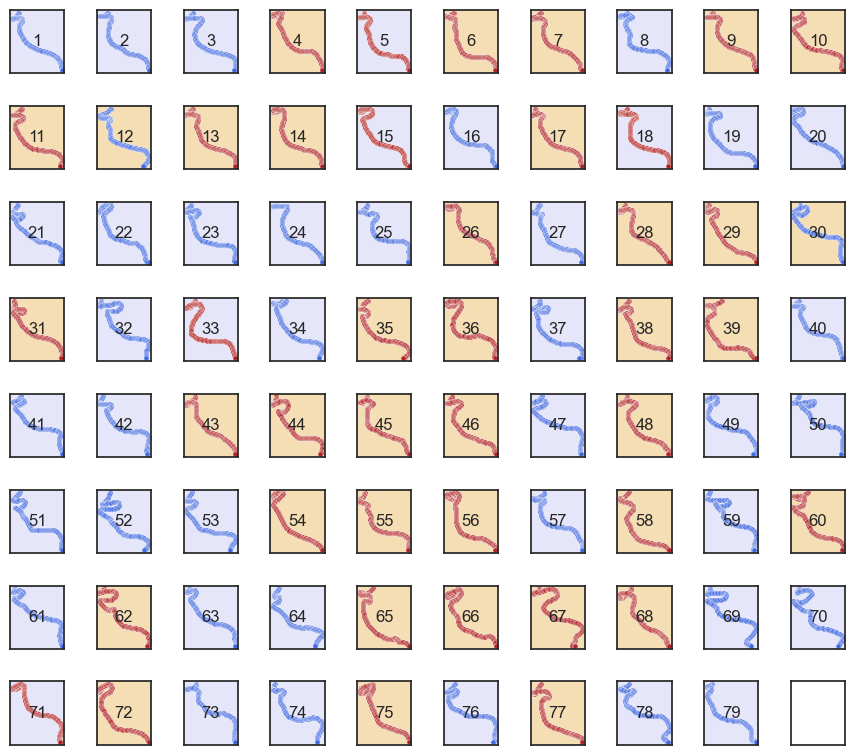

In [26]:
def rotate_curves(curves, angle, axis):
    """
    旋转3D曲线数据集。
    
    :param curves: numpy数组，形状为(n, k, 3)，n是曲线数，k是每条曲线的点数。
    :param angle: 旋转角度，以度为单位。
    :param axis: 旋转轴，'x'、'y'或'z'。
    :return: 旋转后的曲线数据集。
    """
    # 将角度从度转换为弧度
    theta = np.radians(angle)
    
    # 根据轴选择旋转矩阵
    if axis == 'x':
        R = np.array([[1, 0, 0],
                      [0, np.cos(theta), -np.sin(theta)],
                      [0, np.sin(theta), np.cos(theta)]])
    elif axis == 'y':
        R = np.array([[np.cos(theta), 0, np.sin(theta)],
                      [0, 1, 0],
                      [-np.sin(theta), 0, np.cos(theta)]])
    elif axis == 'z':
        R = np.array([[np.cos(theta), -np.sin(theta), 0],
                      [np.sin(theta), np.cos(theta), 0],
                      [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    
    # 应用旋转矩阵到每个点
    rotated_curves = np.dot(curves, R.T)
    
    return rotated_curves

ro = rotate_curves(curve_cs, 45, 'x')  # 绕Z轴旋转45度
ro = rotate_curves(ro, 5, 'z')  # 绕Z轴旋转45度
ro = rotate_curves(ro, -15, 'y')  # 绕Z轴旋转45度

row = 8
col = 10
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 8))


shift_c= []
shift_t= []
print ("elastic_c,elastic_t")
# 遍历每个子图，并在其中绘制一些数据
for i in range(row):
    for j in range(col):
        ax = axes[i, j]  # 获取单个子图对象
        ax.set_xticks([])
        ax.set_yticks([])
        if i*col+j < 79:
            # elastic_c = round(np.dot(c_peak_movement[i*col+j], c_peak_values[i*col+j]),3)
            # elastic_t = round(np.dot(t_peak_movement[i*col+j], t_peak_values[i*col+j]),3)
            elastic_c = round(np.sum(c_peak_movement[i*col+j]),3)
            elastic_t = round(np.sum(t_peak_movement[i*col+j]),3)
            shift_c.append(elastic_c)
            shift_t.append(elastic_t)
            if elastic_c > 0:
                scattercolor = 'firebrick'
            else:
                scattercolor = 'royalblue'

            if elastic_t < 0:
                facecolor = 'lavender'
            else:
                facecolor = 'wheat'
            print (elastic_c,",", elastic_t)
            sns.scatterplot(x=ro[i*col+j,:,0], y=ro[i*col+j,:,1], ax=ax, alpha=0.9,s=14, color=scattercolor)
            # ax.set_title(f'{i*col + j + 1}', fontsize=8)  # 设置子图的标题
            ax.text(0.5, 0.5, f'{i*col + j + 1}', fontsize=12, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.5, f't:{elastic_t}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.3, f'c:{elastic_c}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            ax.set_facecolor(facecolor)

# 调整子图之间的间距
plt.tight_layout()

# 显示整个大图
plt.show()


elastic2_c,elastic2_t
0.868 , 0.884
0.777 , 1.003
0.871 , 0.698
0.91 , 1.508
1.003 , 1.132
0.785 , 1.297
0.933 , 1.796
1.018 , 1.665
0.768 , 0.187
1.092 , 0.375
0.965 , -0.085
1.175 , 1.246
0.934 , 1.921
0.723 , 0.946
1.08 , 1.904
0.894 , 1.096
0.955 , 0.498
0.888 , 1.481
0.812 , 1.003
1.035 , 1.589
1.21 , 1.51
1.056 , 1.653
1.041 , 0.086
0.764 , 0.673
1.137 , 1.997
0.687 , 0.191
1.053 , 0.486
0.811 , 0.99
0.78 , 0.827
1.124 , 0.942
1.181 , 1.157
1.2 , 1.711
0.856 , 0.606
0.992 , 0.978
1.01 , 1.473
0.854 , 0.536
1.141 , 0.967
0.938 , 1.514
1.019 , 2.132
1.006 , 1.801
1.359 , 0.278
1.259 , 1.799
0.86 , 1.077
1.056 , 1.325
1.043 , 1.724
0.848 , 1.918
1.088 , 0.437
0.815 , 1.404
1.13 , 0.735
1.457 , 1.158
1.167 , 0.6
1.27 , 0.938
0.988 , 0.238
0.82 , 0.313
1.055 , 0.082
0.77 , -0.191
1.016 , 1.239
1.032 , 1.834
1.39 , 0.768
0.931 , 0.536
1.18 , -0.036
1.279 , 1.141
0.873 , 1.111
0.799 , 1.281
0.979 , 0.364
1.121 , 1.71
1.06 , 1.53
0.813 , 0.4
1.355 , 0.883
1.38 , 1.025
0.813 , 0.365
0.877

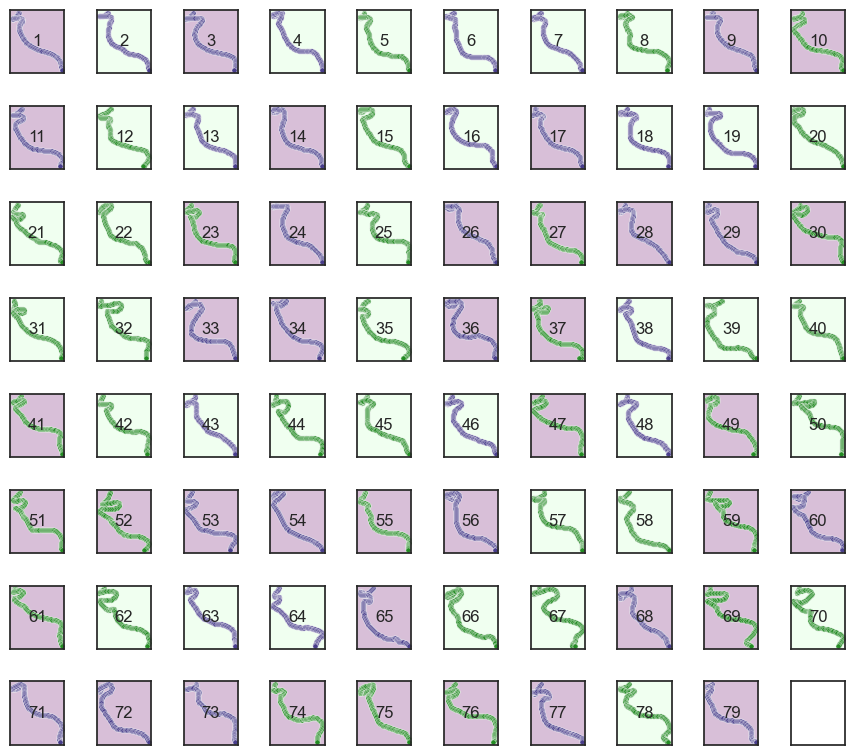

In [27]:


ro = rotate_curves(curve_cs, 45, 'x')  # 绕Z轴旋转45度
ro = rotate_curves(ro, 5, 'z')  # 绕Z轴旋转45度
ro = rotate_curves(ro, -15, 'y')  # 绕Z轴旋转45度

row = 8
col = 10
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 8))

# 遍历每个子图，并在其中绘制一些数据
intense_c = []
intense_t = []
print ("elastic2_c,elastic2_t")
for i in range(row):
    for j in range(col):
        ax = axes[i, j]  # 获取单个子图对象
        ax.set_xticks([])
        ax.set_yticks([])
        if i*col+j < 79:
            # elastic_c = round(np.dot(c_peak_movement[i*col+j], c_peak_values[i*col+j]),3)
            # elastic_t = round(np.dot(t_peak_movement[i*col+j], t_peak_values[i*col+j]),3)
            # elastic_c = round(np.sum(c_peak_values[i*col+j]),3)
            # elastic_t = round(np.sum(t_peak_values[i*col+j]),3)
            elastic2_c = round(np.mean(c_peak_values[i*col+j]),3)
            elastic2_t = round(np.mean(t_peak_values[i*col+j]),3)
            intense_c.append(elastic2_c)
            intense_t.append(elastic2_t)
            if elastic2_c > 1:
                scattercolor = 'forestgreen'
            else:
                scattercolor = 'darkslateblue'
            if elastic2_t < 1:
                facecolor = 'thistle'
            else:
                facecolor = 'honeydew'
            print (elastic2_c,",", elastic2_t)
            sns.scatterplot(x=ro[i*col+j,:,0], y=ro[i*col+j,:,1], ax=ax, alpha=0.9,s=14, color=scattercolor)
            # ax.set_title(f'{i*col + j + 1}', fontsize=8)  # 设置子图的标题
            ax.text(0.5, 0.5, f'{i*col + j + 1}', fontsize=12, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.5, f't:{elastic_t}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.3, f'c:{elastic_c}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            ax.set_facecolor(facecolor)

# 调整子图之间的间距
plt.tight_layout()

# 显示整个大图
plt.show()

shift_c = np.array(shift_c)
shift_t = np.array(shift_t)
intense_c = np.array(intense_c)
intense_t = np.array(intense_t)


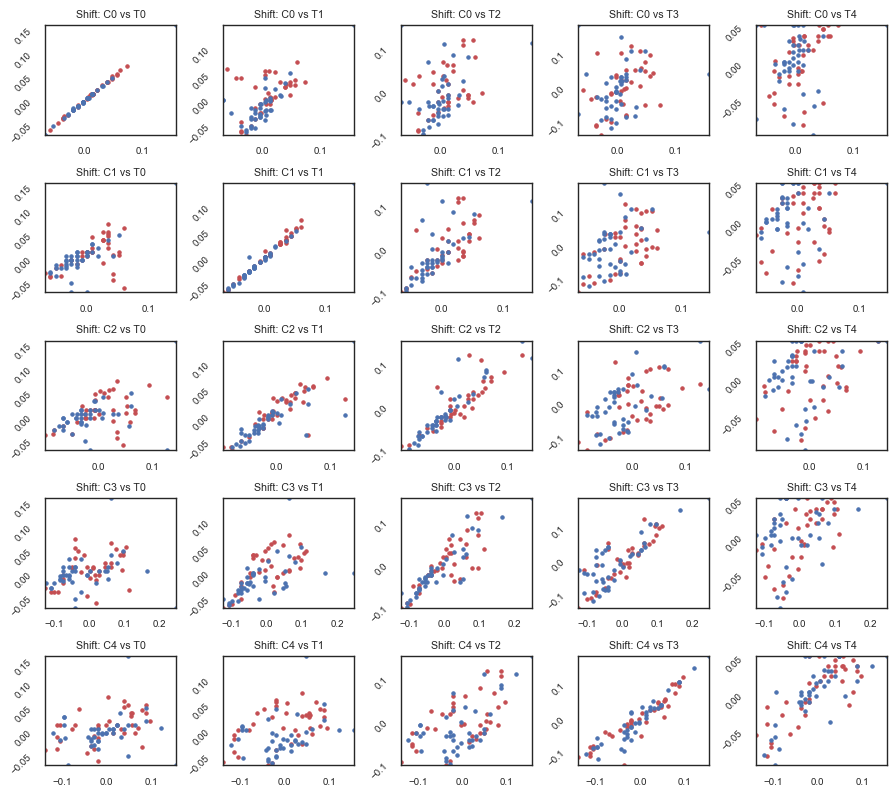

In [28]:
row = 5
col = 5

shift_c = np.array(shift_c)
shift_t = np.array(shift_t)
intense_c = np.array(intense_c)
intense_t = np.array(intense_t)
sns.set_context('paper', font_scale=0.8)
sns.set_style('white')
for c_item in [c_peak_movement]:
    for t_item in [t_peak_movement]:
        fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 8), dpi=100)
        # 遍历每个子图，并在其中绘制一些数据
        for i in range(row):
            for j in range(col):
                ax = axes[i, j]  # 获取单个子图对象

                mask_0 = (intense_c < 1)
                mask_1 = (intense_c >= 1)
                ax.scatter(c_item[mask_0, i], t_item[mask_0, j], alpha=1, marker='.', color="r")
                ax.scatter(c_item[mask_1, i], t_item[mask_1, j], alpha=1, marker='.', color="b")
                plt.setp(ax.get_yticklabels(), rotation=45)
                # plt.setp(ax.get_xticklabels(), rotation=45)
                # ax.set_ylim(-0.2, 0.2)
                ax.autoscale(enable=True, axis='x', tight=True)
                ax.autoscale(enable=True, axis='y', tight=True)
                ax.set_title(f'Shift: C{i} vs T{j}')
                
                
        plt.tight_layout()
        # plt.legend()

In [38]:
for i in range(len(files)):
    print (files[i].split("\\")[-1].split(".")[0])

BG0001_ICA_L
BG0012_ICA_L
BH0026_ICA_L
BH0034_ICA_L
BH0020_ICA_R
BH0020_ICA_L
BG0022_ICA_R
BG0007_ICA_L
BI0001_ICA_L
BH0035_ICA_L
BH0018_ICA_L
BH0019_ICA_L
BH0017_ICA_L
BH0017_ICA_R
BH0031_ICA_R
BH0026_ICA_R
BH0035_ICA_R
BG0007_ICA_R
BH0006_ICA_R
BG0020_ICA_R
BH0036_ICA_R
BH0034_ICA_R
BG0006_ICA_L
BH0031_ICA_L
BH0019_ICA_R
BI0001_ICA_R
BH0030_ICA_L
BG0022_ICA_L
BH0013_ICA_L
BG0010_ICA_L
BH0036_ICA_L
BH0038_ICA_R
BH0009_ICA_L
BH0040_ICA_R
BG0004_ICA_L
BH0009_ICA_R
BH0018_ICA_R
BH0005_ICA_R
BH0021_ICA_L
BG0012_ICA_R
BG0010_ICA_R
BG0004_ICA_R
BG0019_ICA_L
BH0039_ICA_R
BG0006_ICA_R
BH0006_ICA_L
BG0009_ICA_L
BH0013_ICA_R
BG0020_ICA_L
BG0011_ICA_R
BH0038_ICA_L
BH0030_ICA_R
BH0011_ICA_L
BH0029_ICA_L
BH0005_ICA_L
BH0029_ICA_R
BH0010_ICA_R
BG0021_ICA_R
BG0011_ICA_L
BH0039_ICA_L
BG0009_ICA_R
BH0016_ICA_R
BH0024_ICA_R
BH0011_ICA_R
BH0014_ICA_L
BG0017_ICA_L
BG0018_ICA_R
BG0019_ICA_R
BG0018_ICA_L
BH0016_ICA_L
BG0008_ICA_R
BH0023_ICA_L
BG0008_ICA_L
BG0001_ICA_R
BG0017_ICA_R
BH0025_ICA_R
BH0014_ICA_R

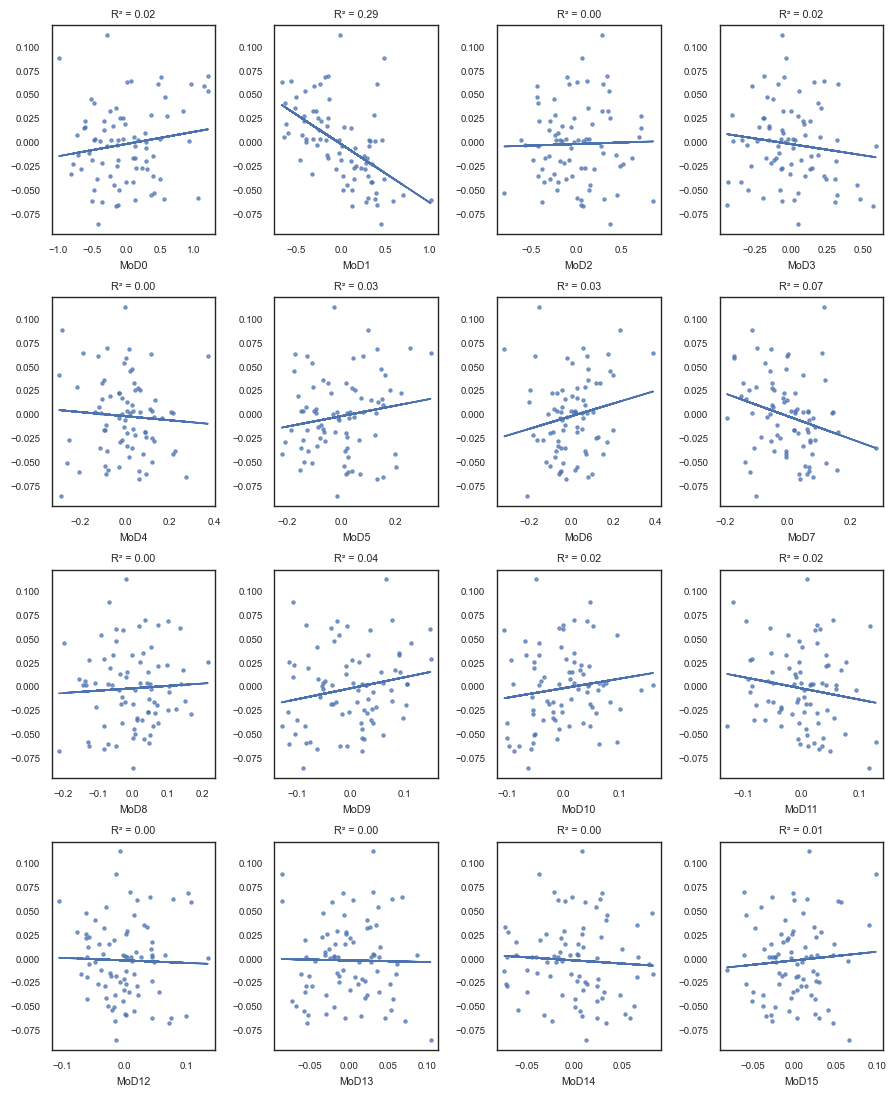

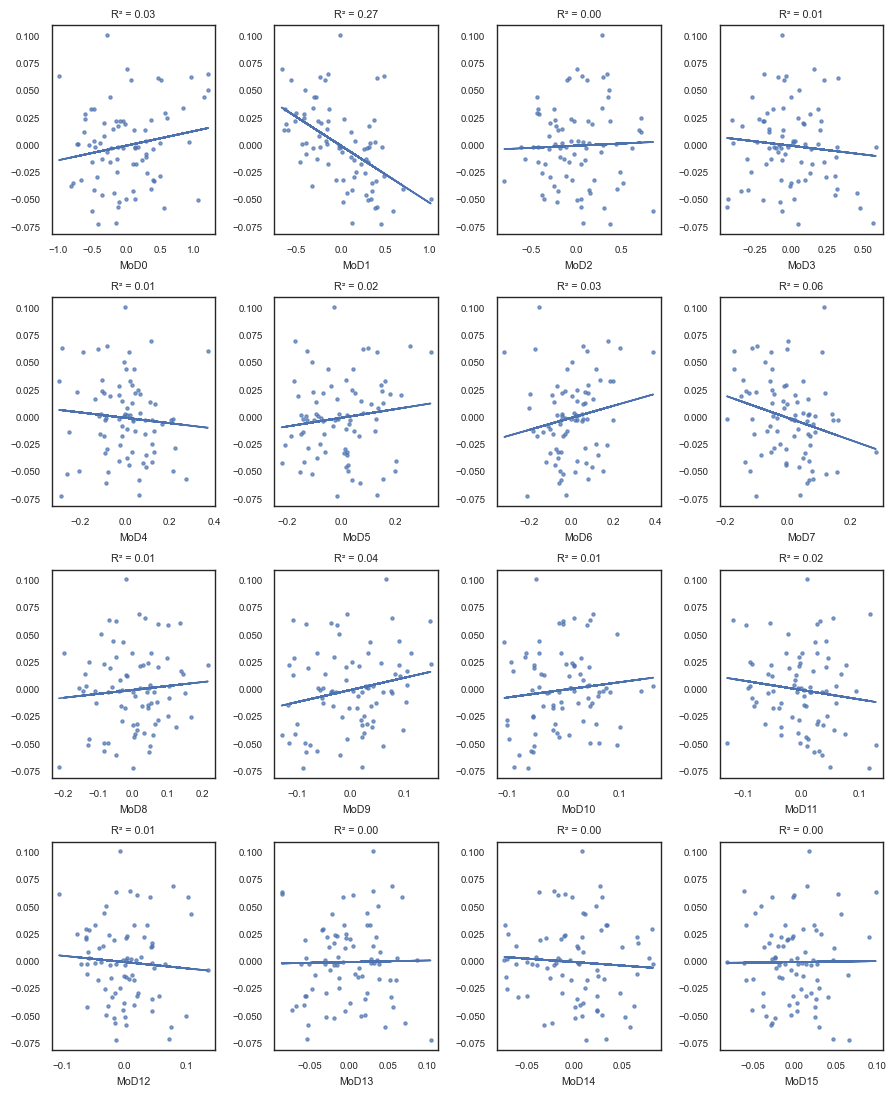

In [29]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Assuming tangent_projected_data and c_peak_movement are already defined
row = 4
col = 4

# for item in [c_peak_values,t_peak_values]:
for item in [c_peak_movement,t_peak_movement]:
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 11))

    for i in range(row):
        for j in range(col):
            ax = axes[i, j]
            x = tangent_projected_data[:, row * i + j].reshape(-1, 1)
            y = np.mean(item, axis=1)

            # Scatter plot
            ax.scatter(x, y, alpha=0.7, marker='.')

            # Linear regression
            model = LinearRegression()
            model.fit(x, y)
            y_pred = model.predict(x)

            # Plot the linear fit
            ax.plot(x, y_pred, color='b')

            # Evaluate the fit
            r2 = r2_score(y, y_pred)
            ax.set_title(f'R² = {r2:.2f}')
            ax.set_xlabel(f'MoD{row * i + j}')

    plt.tight_layout()
    plt.show()


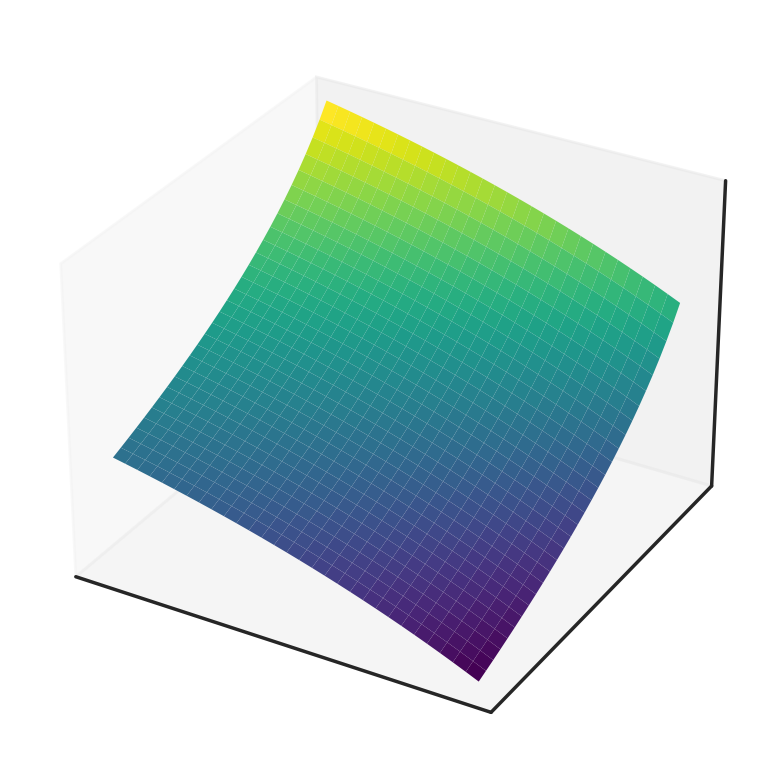

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sns.set_context('notebook', font_scale=1.8)
# 创建数据
Time = np.linspace(20, 150, 30)  # 时间范围
Mass = np.linspace(40, 500, 30)  # 质量范围
Time, Mass = np.meshgrid(Time, Mass)

# 计算ΔV (这里假设一个简单的公式来模拟)
DeltaV = 0.05 * (1 - np.exp(-Time / 150)) - 0.03 * np.log(Mass / 100 + 1)
# 计算DeltaV (凹凸不平，Z轴中心高，其他地方低)
# DeltaV = np.exp(-((Time - 150)**2 + (Mass - 100)**2) / 5000)  # 中心区域高
# DeltaV += 0.02 * np.sin(5 * Time) * np.cos(5 * Mass)  # 周期性凹凸
# DeltaV *= 0.8  # 调整整体高度

# 创建3D图形
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面
surf = ax.plot_surface(Time, Mass, DeltaV, cmap='viridis', edgecolor='none')

# 绘制数据点
# ax.scatter([120], [500], [0.03], color='red', s=100, label='Special Point', marker='o')  # 类似于图中的红色圆圈


# ax.scatter(Time.flatten()[np.random.randint(20, 150, 5)], Mass.flatten()[np.random.randint(20, 150, 5)], DeltaV.flatten()[random_points], color='w',edgecolors='k', s=3, linewidth=0.5)  # 用白色点表示数据点 

# 添加颜色条
# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# 设置标签
# ax.set_xlabel('Geometric $\\alpha$')
# ax.set_ylabel('Geometric $\\beta$')
# ax.set_zlabel('Hemodynamic')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(elev=30, azim=120)  # 修改视角，使其尽量接近图片
plt.show()
